In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np
import pandas as pd 
import random 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

In [2]:
# train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims) # mean
        self.linear3 = nn.Linear(128, latent_dims) # covar
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        self.mu = mu
        self.sigma = sigma
        return z, mu, sigma


    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    

    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z, _, _ = self.encoder(x)
        return self.decoder(z)

    #def get_latent_dist(self, x):
    #    x = x.to(device)
    #    z = self.encoder(x)
    #    return z, 

In [4]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(16, e

In [66]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            z, _, _ = encoder(img)
            rec_img  = decoder(z)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()  

	 partial train loss (single batch): 19932.181641
	 partial train loss (single batch): 19897.900391
	 partial train loss (single batch): 19736.386719
	 partial train loss (single batch): 19922.037109
	 partial train loss (single batch): 19721.527344
	 partial train loss (single batch): 19651.386719
	 partial train loss (single batch): 19510.132812
	 partial train loss (single batch): 19484.542969
	 partial train loss (single batch): 19512.167969
	 partial train loss (single batch): 19195.169922
	 partial train loss (single batch): 19336.994141
	 partial train loss (single batch): 19471.050781
	 partial train loss (single batch): 19212.191406
	 partial train loss (single batch): 19138.308594
	 partial train loss (single batch): 19070.496094
	 partial train loss (single batch): 19070.791016
	 partial train loss (single batch): 18985.796875
	 partial train loss (single batch): 18703.425781
	 partial train loss (single batch): 18595.929688
	 partial train loss (single batch): 18668.890625


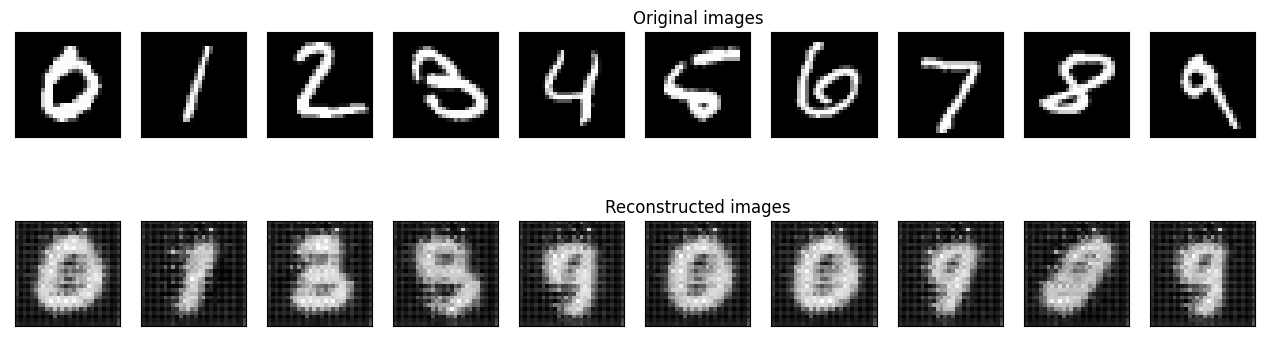

	 partial train loss (single batch): 13391.195312
	 partial train loss (single batch): 13293.012695
	 partial train loss (single batch): 13141.356445
	 partial train loss (single batch): 13460.007812
	 partial train loss (single batch): 13432.485352
	 partial train loss (single batch): 13457.108398
	 partial train loss (single batch): 13329.755859
	 partial train loss (single batch): 13217.951172
	 partial train loss (single batch): 13418.353516
	 partial train loss (single batch): 13067.871094
	 partial train loss (single batch): 13339.820312
	 partial train loss (single batch): 13287.705078
	 partial train loss (single batch): 13184.191406
	 partial train loss (single batch): 13202.241211
	 partial train loss (single batch): 13009.348633
	 partial train loss (single batch): 13309.696289
	 partial train loss (single batch): 13162.735352
	 partial train loss (single batch): 13043.555664
	 partial train loss (single batch): 12847.716797
	 partial train loss (single batch): 12978.436523


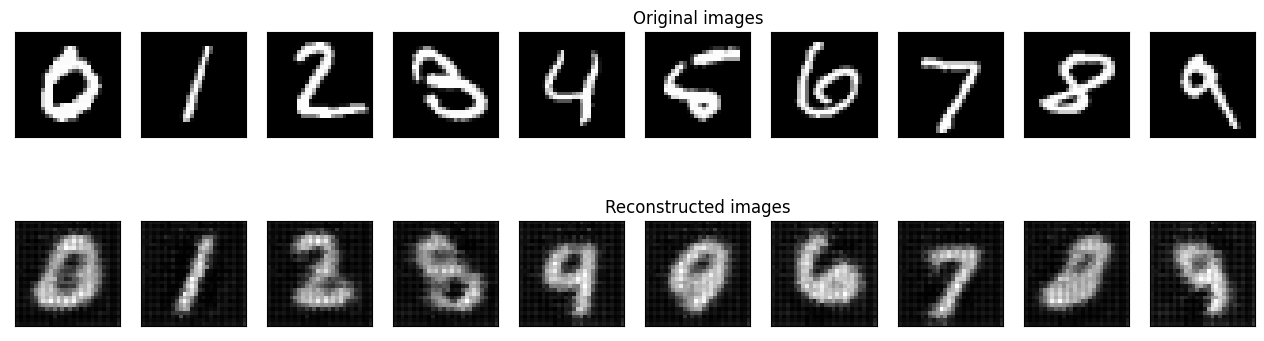

	 partial train loss (single batch): 10874.694336
	 partial train loss (single batch): 10741.208984
	 partial train loss (single batch): 10663.954102
	 partial train loss (single batch): 10883.616211
	 partial train loss (single batch): 11045.719727
	 partial train loss (single batch): 10940.764648
	 partial train loss (single batch): 11013.175781
	 partial train loss (single batch): 10761.515625
	 partial train loss (single batch): 11125.862305
	 partial train loss (single batch): 10656.260742
	 partial train loss (single batch): 10958.878906
	 partial train loss (single batch): 10876.265625
	 partial train loss (single batch): 10816.185547
	 partial train loss (single batch): 10844.875000
	 partial train loss (single batch): 10636.091797
	 partial train loss (single batch): 10898.267578
	 partial train loss (single batch): 10800.255859
	 partial train loss (single batch): 10709.685547
	 partial train loss (single batch): 10591.623047
	 partial train loss (single batch): 10650.491211


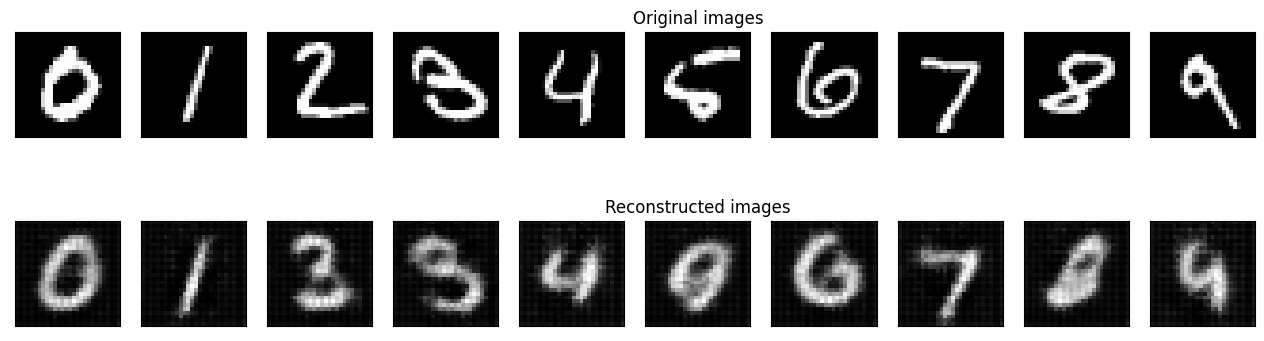

	 partial train loss (single batch): 9752.908203
	 partial train loss (single batch): 9704.208008
	 partial train loss (single batch): 9731.566406
	 partial train loss (single batch): 9869.042969
	 partial train loss (single batch): 10013.054688
	 partial train loss (single batch): 9839.813477
	 partial train loss (single batch): 9955.017578
	 partial train loss (single batch): 9772.889648
	 partial train loss (single batch): 10083.577148
	 partial train loss (single batch): 9733.015625
	 partial train loss (single batch): 9966.521484
	 partial train loss (single batch): 9851.861328
	 partial train loss (single batch): 9982.075195
	 partial train loss (single batch): 9795.576172
	 partial train loss (single batch): 9714.155273
	 partial train loss (single batch): 9956.662109
	 partial train loss (single batch): 9819.701172
	 partial train loss (single batch): 9800.829102
	 partial train loss (single batch): 9685.809570
	 partial train loss (single batch): 9762.375000
	 partial train lo

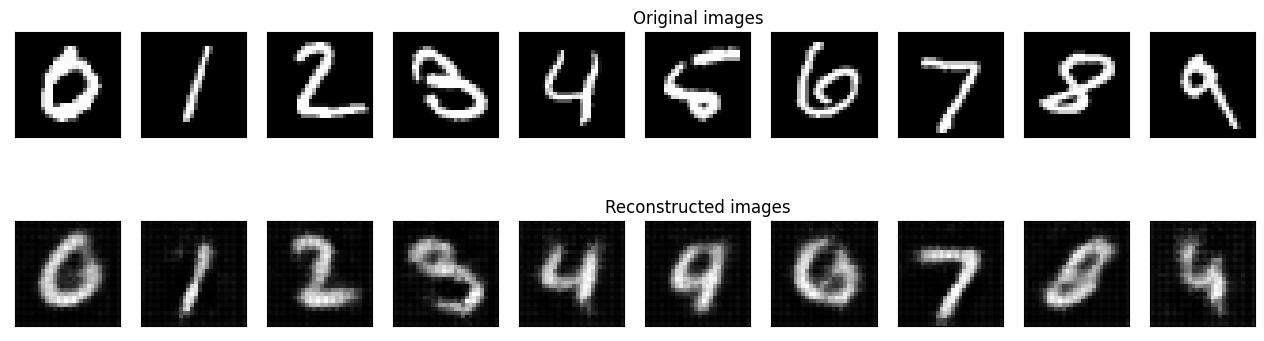

	 partial train loss (single batch): 9375.015625
	 partial train loss (single batch): 9256.452148
	 partial train loss (single batch): 9232.959961
	 partial train loss (single batch): 9377.551758
	 partial train loss (single batch): 9628.505859
	 partial train loss (single batch): 9412.285156
	 partial train loss (single batch): 9607.956055
	 partial train loss (single batch): 9246.317383
	 partial train loss (single batch): 9673.788086
	 partial train loss (single batch): 9173.429688
	 partial train loss (single batch): 9506.748047
	 partial train loss (single batch): 9421.834961
	 partial train loss (single batch): 9584.837891
	 partial train loss (single batch): 9374.592773
	 partial train loss (single batch): 9207.587891
	 partial train loss (single batch): 9537.370117
	 partial train loss (single batch): 9402.700195
	 partial train loss (single batch): 9375.020508
	 partial train loss (single batch): 9223.787109
	 partial train loss (single batch): 9401.456055
	 partial train loss

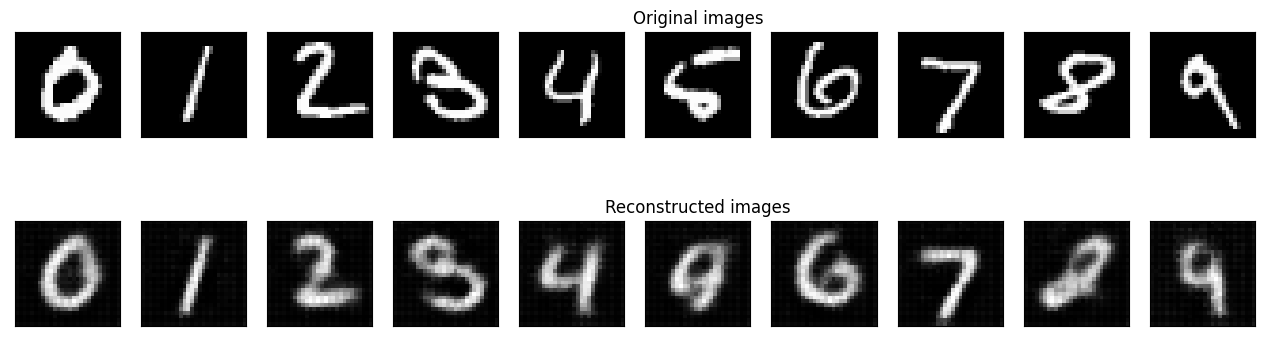

	 partial train loss (single batch): 9072.046875
	 partial train loss (single batch): 8963.462891
	 partial train loss (single batch): 9021.443359
	 partial train loss (single batch): 9187.393555
	 partial train loss (single batch): 9320.322266
	 partial train loss (single batch): 9152.716797
	 partial train loss (single batch): 9394.467773
	 partial train loss (single batch): 9077.217773
	 partial train loss (single batch): 9334.103516
	 partial train loss (single batch): 9008.428711
	 partial train loss (single batch): 9360.570312
	 partial train loss (single batch): 9122.816406
	 partial train loss (single batch): 9277.650391
	 partial train loss (single batch): 9134.525391
	 partial train loss (single batch): 9031.295898
	 partial train loss (single batch): 9263.804688
	 partial train loss (single batch): 9179.705078
	 partial train loss (single batch): 9166.833984
	 partial train loss (single batch): 8992.299805
	 partial train loss (single batch): 9071.802734
	 partial train loss

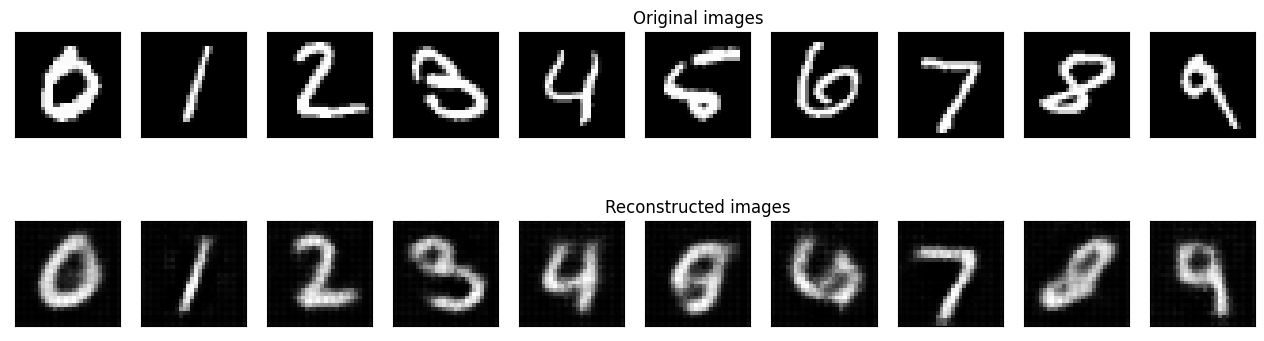

	 partial train loss (single batch): 8867.642578
	 partial train loss (single batch): 8796.839844
	 partial train loss (single batch): 8877.017578
	 partial train loss (single batch): 9042.237305
	 partial train loss (single batch): 9188.977539
	 partial train loss (single batch): 8955.072266
	 partial train loss (single batch): 9209.816406
	 partial train loss (single batch): 8947.199219
	 partial train loss (single batch): 9168.620117
	 partial train loss (single batch): 8843.425781
	 partial train loss (single batch): 9127.612305
	 partial train loss (single batch): 9042.781250
	 partial train loss (single batch): 9141.056641
	 partial train loss (single batch): 8900.335938
	 partial train loss (single batch): 8829.308594
	 partial train loss (single batch): 9099.441406
	 partial train loss (single batch): 9038.284180
	 partial train loss (single batch): 9039.804688
	 partial train loss (single batch): 8863.764648
	 partial train loss (single batch): 9022.117188
	 partial train loss

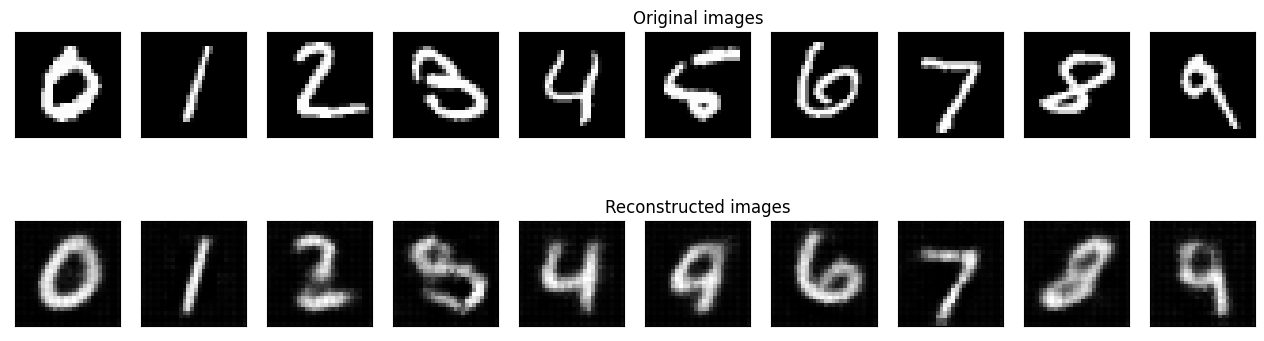

	 partial train loss (single batch): 8817.665039
	 partial train loss (single batch): 8689.896484
	 partial train loss (single batch): 8717.269531
	 partial train loss (single batch): 8917.214844
	 partial train loss (single batch): 9108.026367
	 partial train loss (single batch): 8837.356445
	 partial train loss (single batch): 9073.280273
	 partial train loss (single batch): 8854.694336
	 partial train loss (single batch): 9115.423828
	 partial train loss (single batch): 8730.369141
	 partial train loss (single batch): 8950.546875
	 partial train loss (single batch): 8864.724609
	 partial train loss (single batch): 9007.435547
	 partial train loss (single batch): 8885.880859
	 partial train loss (single batch): 8727.712891
	 partial train loss (single batch): 9058.455078
	 partial train loss (single batch): 9006.082031
	 partial train loss (single batch): 8889.965820
	 partial train loss (single batch): 8731.328125
	 partial train loss (single batch): 8896.837891
	 partial train loss

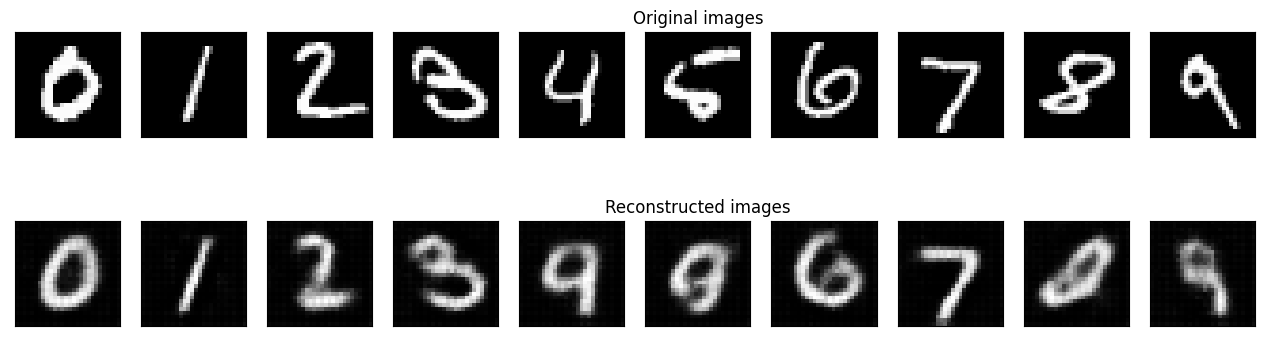

	 partial train loss (single batch): 8776.843750
	 partial train loss (single batch): 8561.492188
	 partial train loss (single batch): 8609.838867
	 partial train loss (single batch): 8762.907227
	 partial train loss (single batch): 9067.505859
	 partial train loss (single batch): 8758.453125
	 partial train loss (single batch): 9006.236328
	 partial train loss (single batch): 8783.871094
	 partial train loss (single batch): 9008.380859
	 partial train loss (single batch): 8742.770508
	 partial train loss (single batch): 8901.155273
	 partial train loss (single batch): 8848.440430
	 partial train loss (single batch): 8907.578125
	 partial train loss (single batch): 8655.486328
	 partial train loss (single batch): 8618.371094
	 partial train loss (single batch): 9019.910156
	 partial train loss (single batch): 8896.458008
	 partial train loss (single batch): 8813.865234
	 partial train loss (single batch): 8648.556641
	 partial train loss (single batch): 8823.427734
	 partial train loss

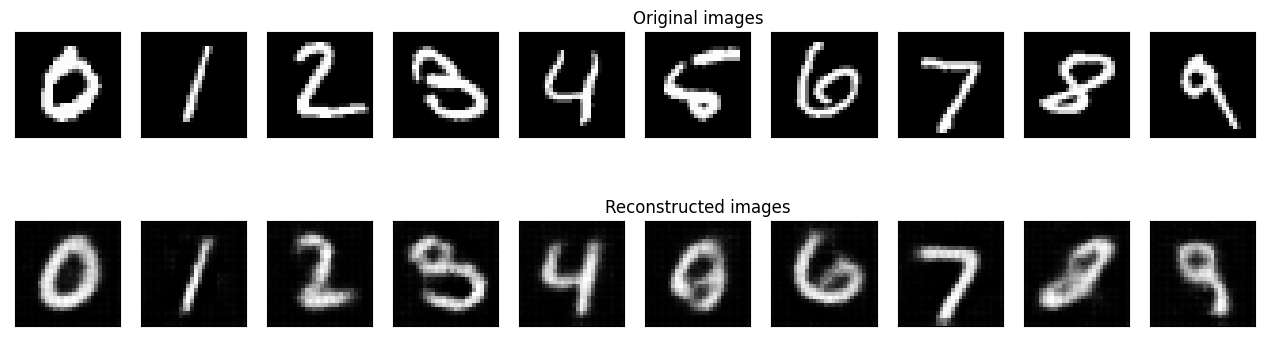

	 partial train loss (single batch): 8798.682617
	 partial train loss (single batch): 8576.135742
	 partial train loss (single batch): 8506.071289
	 partial train loss (single batch): 8718.814453
	 partial train loss (single batch): 8925.074219
	 partial train loss (single batch): 8713.228516
	 partial train loss (single batch): 8965.312500
	 partial train loss (single batch): 8747.308594
	 partial train loss (single batch): 8920.515625
	 partial train loss (single batch): 8698.475586
	 partial train loss (single batch): 8858.271484
	 partial train loss (single batch): 8732.501953
	 partial train loss (single batch): 8873.429688
	 partial train loss (single batch): 8669.535156
	 partial train loss (single batch): 8531.609375
	 partial train loss (single batch): 8891.029297
	 partial train loss (single batch): 8801.698242
	 partial train loss (single batch): 8732.525391
	 partial train loss (single batch): 8565.371094
	 partial train loss (single batch): 8746.798828
	 partial train loss

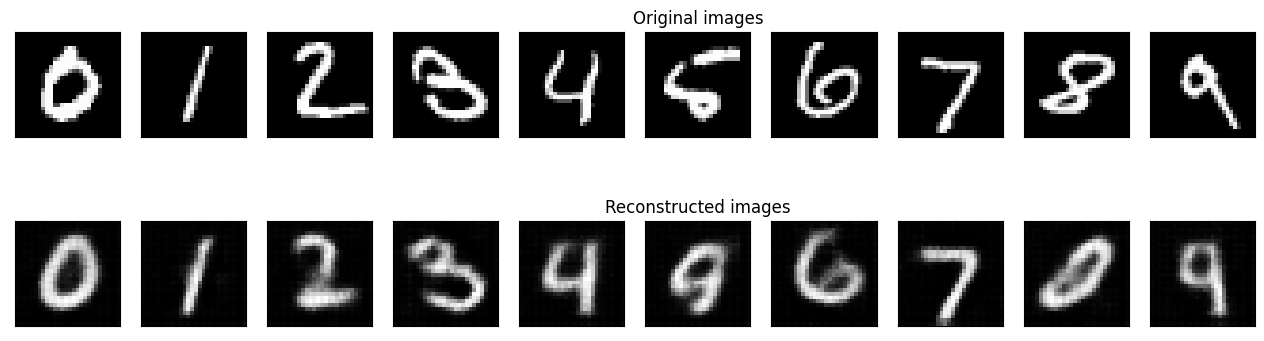

	 partial train loss (single batch): 8602.323242
	 partial train loss (single batch): 8545.977539
	 partial train loss (single batch): 8468.492188
	 partial train loss (single batch): 8624.068359
	 partial train loss (single batch): 8928.572266
	 partial train loss (single batch): 8699.132812
	 partial train loss (single batch): 8940.138672
	 partial train loss (single batch): 8715.281250
	 partial train loss (single batch): 8888.578125
	 partial train loss (single batch): 8679.142578
	 partial train loss (single batch): 8751.107422
	 partial train loss (single batch): 8624.249023
	 partial train loss (single batch): 8847.310547
	 partial train loss (single batch): 8647.724609
	 partial train loss (single batch): 8532.597656
	 partial train loss (single batch): 8823.066406
	 partial train loss (single batch): 8725.416992
	 partial train loss (single batch): 8749.552734
	 partial train loss (single batch): 8497.329102
	 partial train loss (single batch): 8679.244141
	 partial train loss

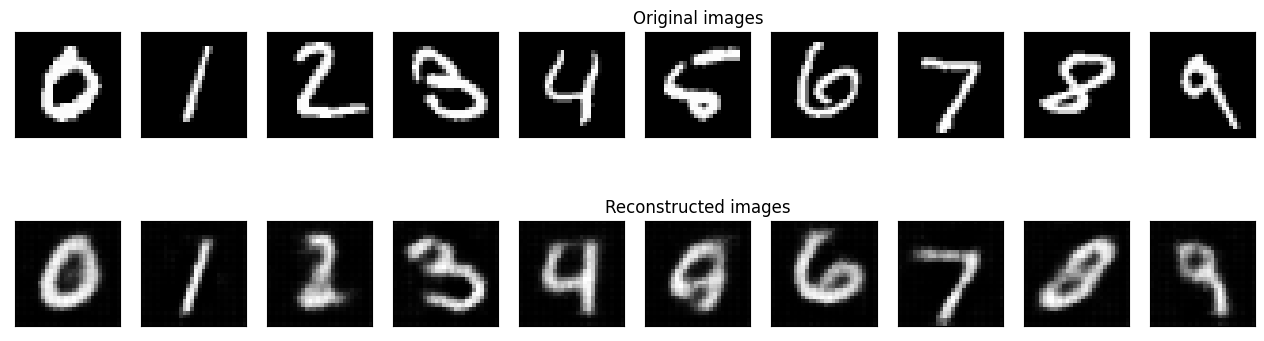

	 partial train loss (single batch): 8661.073242
	 partial train loss (single batch): 8429.376953
	 partial train loss (single batch): 8489.815430
	 partial train loss (single batch): 8601.462891
	 partial train loss (single batch): 8784.695312
	 partial train loss (single batch): 8583.999023
	 partial train loss (single batch): 8852.622070
	 partial train loss (single batch): 8627.279297
	 partial train loss (single batch): 8750.397461
	 partial train loss (single batch): 8584.105469
	 partial train loss (single batch): 8785.011719
	 partial train loss (single batch): 8673.934570
	 partial train loss (single batch): 8774.414062
	 partial train loss (single batch): 8557.830078
	 partial train loss (single batch): 8500.890625
	 partial train loss (single batch): 8793.188477
	 partial train loss (single batch): 8708.293945
	 partial train loss (single batch): 8610.039062
	 partial train loss (single batch): 8470.451172
	 partial train loss (single batch): 8626.345703
	 partial train loss

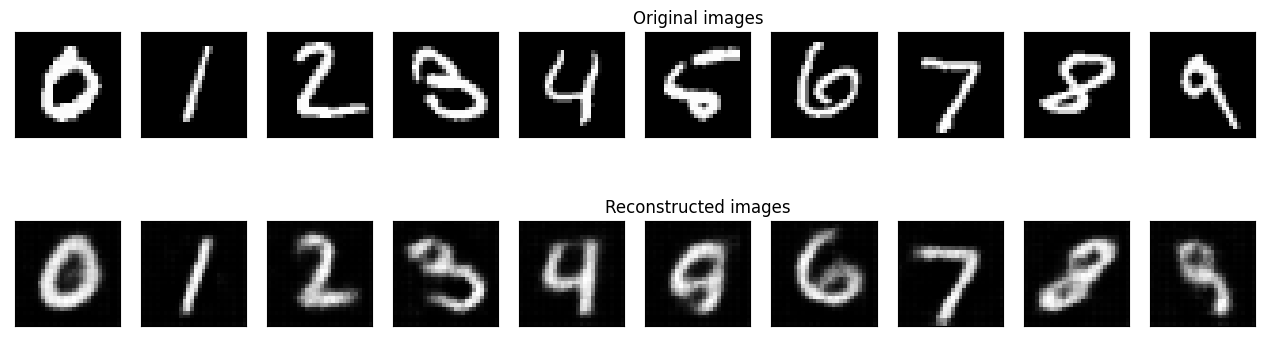

	 partial train loss (single batch): 8556.419922
	 partial train loss (single batch): 8405.012695
	 partial train loss (single batch): 8410.085938
	 partial train loss (single batch): 8573.551758
	 partial train loss (single batch): 8765.865234
	 partial train loss (single batch): 8528.953125
	 partial train loss (single batch): 8872.524414
	 partial train loss (single batch): 8548.771484
	 partial train loss (single batch): 8763.442383
	 partial train loss (single batch): 8525.362305
	 partial train loss (single batch): 8721.578125
	 partial train loss (single batch): 8570.251953
	 partial train loss (single batch): 8698.346680
	 partial train loss (single batch): 8531.035156
	 partial train loss (single batch): 8401.465820
	 partial train loss (single batch): 8722.439453
	 partial train loss (single batch): 8777.285156
	 partial train loss (single batch): 8607.212891
	 partial train loss (single batch): 8464.224609
	 partial train loss (single batch): 8609.613281
	 partial train loss

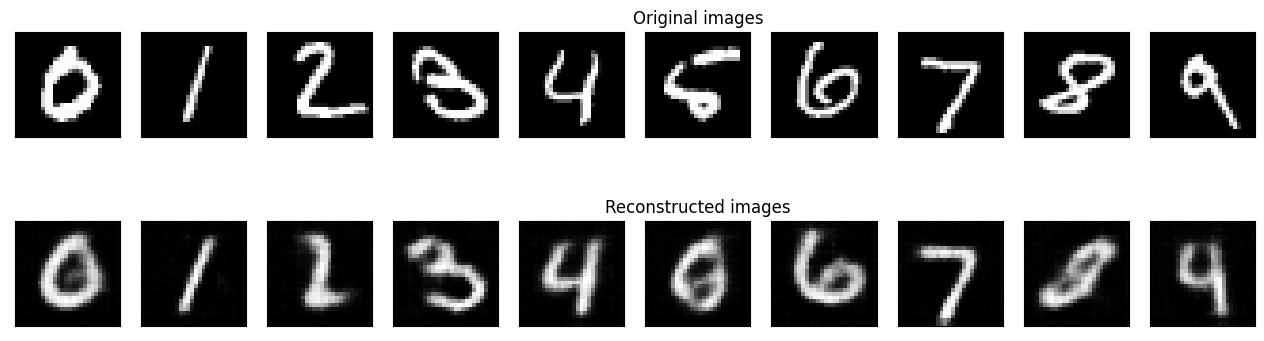

	 partial train loss (single batch): 8515.693359
	 partial train loss (single batch): 8373.359375
	 partial train loss (single batch): 8385.656250
	 partial train loss (single batch): 8593.935547
	 partial train loss (single batch): 8770.376953
	 partial train loss (single batch): 8494.517578
	 partial train loss (single batch): 8759.805664
	 partial train loss (single batch): 8601.923828
	 partial train loss (single batch): 8729.257812
	 partial train loss (single batch): 8509.888672
	 partial train loss (single batch): 8619.384766
	 partial train loss (single batch): 8521.977539
	 partial train loss (single batch): 8665.516602
	 partial train loss (single batch): 8434.574219
	 partial train loss (single batch): 8478.129883
	 partial train loss (single batch): 8687.534180
	 partial train loss (single batch): 8600.167969
	 partial train loss (single batch): 8657.996094
	 partial train loss (single batch): 8313.985352
	 partial train loss (single batch): 8521.179688
	 partial train loss

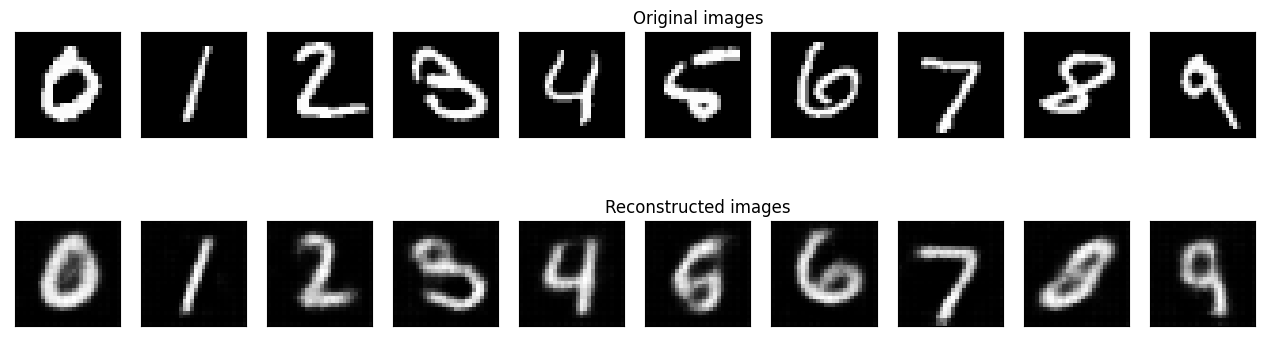

	 partial train loss (single batch): 8547.007812
	 partial train loss (single batch): 8362.747070
	 partial train loss (single batch): 8290.253906
	 partial train loss (single batch): 8522.112305
	 partial train loss (single batch): 8662.203125
	 partial train loss (single batch): 8510.900391
	 partial train loss (single batch): 8742.076172
	 partial train loss (single batch): 8530.092773
	 partial train loss (single batch): 8691.824219
	 partial train loss (single batch): 8476.599609
	 partial train loss (single batch): 8650.645508
	 partial train loss (single batch): 8545.637695
	 partial train loss (single batch): 8651.955078
	 partial train loss (single batch): 8441.472656
	 partial train loss (single batch): 8390.666992
	 partial train loss (single batch): 8715.353516
	 partial train loss (single batch): 8562.385742
	 partial train loss (single batch): 8534.523438
	 partial train loss (single batch): 8352.258789
	 partial train loss (single batch): 8507.853516
	 partial train loss

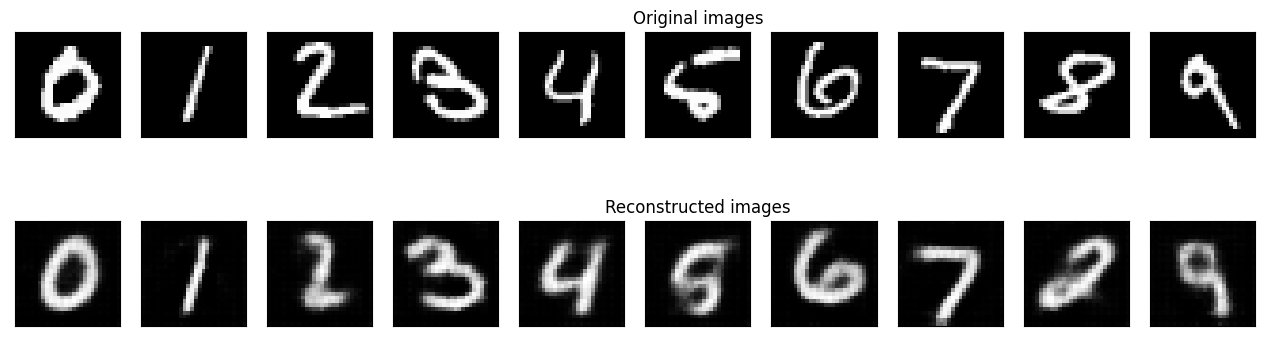

	 partial train loss (single batch): 8507.298828
	 partial train loss (single batch): 8323.644531
	 partial train loss (single batch): 8315.869141
	 partial train loss (single batch): 8573.036133
	 partial train loss (single batch): 8781.157227
	 partial train loss (single batch): 8547.953125
	 partial train loss (single batch): 8746.050781
	 partial train loss (single batch): 8548.775391
	 partial train loss (single batch): 8697.023438
	 partial train loss (single batch): 8478.240234
	 partial train loss (single batch): 8656.185547
	 partial train loss (single batch): 8431.494141
	 partial train loss (single batch): 8591.955078
	 partial train loss (single batch): 8308.357422
	 partial train loss (single batch): 8313.214844
	 partial train loss (single batch): 8662.029297
	 partial train loss (single batch): 8694.635742
	 partial train loss (single batch): 8511.373047
	 partial train loss (single batch): 8349.152344
	 partial train loss (single batch): 8455.251953
	 partial train loss

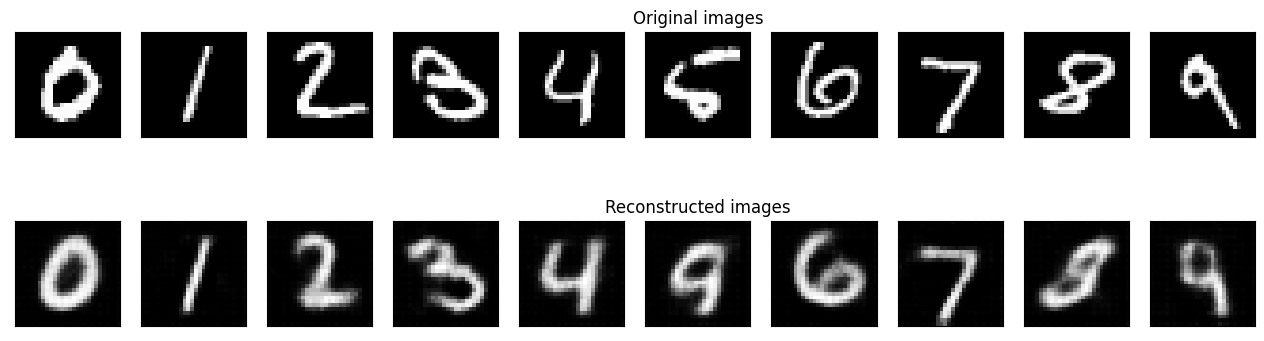

	 partial train loss (single batch): 8454.756836
	 partial train loss (single batch): 8300.153320
	 partial train loss (single batch): 8299.160156
	 partial train loss (single batch): 8479.481445
	 partial train loss (single batch): 8721.526367
	 partial train loss (single batch): 8445.099609
	 partial train loss (single batch): 8703.320312
	 partial train loss (single batch): 8430.892578
	 partial train loss (single batch): 8632.861328
	 partial train loss (single batch): 8496.322266
	 partial train loss (single batch): 8615.612305
	 partial train loss (single batch): 8504.866211
	 partial train loss (single batch): 8513.815430
	 partial train loss (single batch): 8321.314453
	 partial train loss (single batch): 8433.254883
	 partial train loss (single batch): 8671.382812
	 partial train loss (single batch): 8557.441406
	 partial train loss (single batch): 8455.943359
	 partial train loss (single batch): 8270.966797
	 partial train loss (single batch): 8479.820312
	 partial train loss

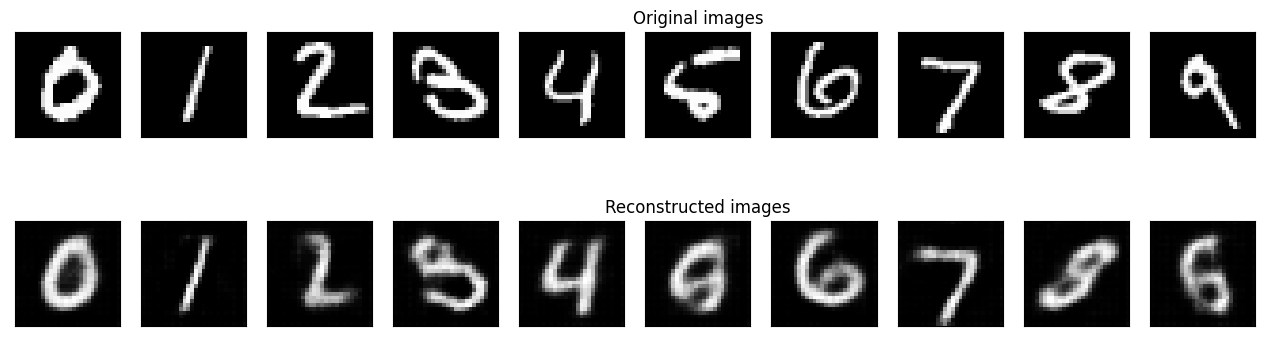

	 partial train loss (single batch): 8399.706055
	 partial train loss (single batch): 8273.128906
	 partial train loss (single batch): 8263.470703
	 partial train loss (single batch): 8429.219727
	 partial train loss (single batch): 8629.459961
	 partial train loss (single batch): 8386.548828
	 partial train loss (single batch): 8605.037109
	 partial train loss (single batch): 8435.762695
	 partial train loss (single batch): 8640.092773
	 partial train loss (single batch): 8367.853516
	 partial train loss (single batch): 8587.956055
	 partial train loss (single batch): 8450.759766
	 partial train loss (single batch): 8512.332031
	 partial train loss (single batch): 8250.382812
	 partial train loss (single batch): 8274.256836
	 partial train loss (single batch): 8567.466797
	 partial train loss (single batch): 8569.230469
	 partial train loss (single batch): 8467.148438
	 partial train loss (single batch): 8274.445312
	 partial train loss (single batch): 8460.132812
	 partial train loss

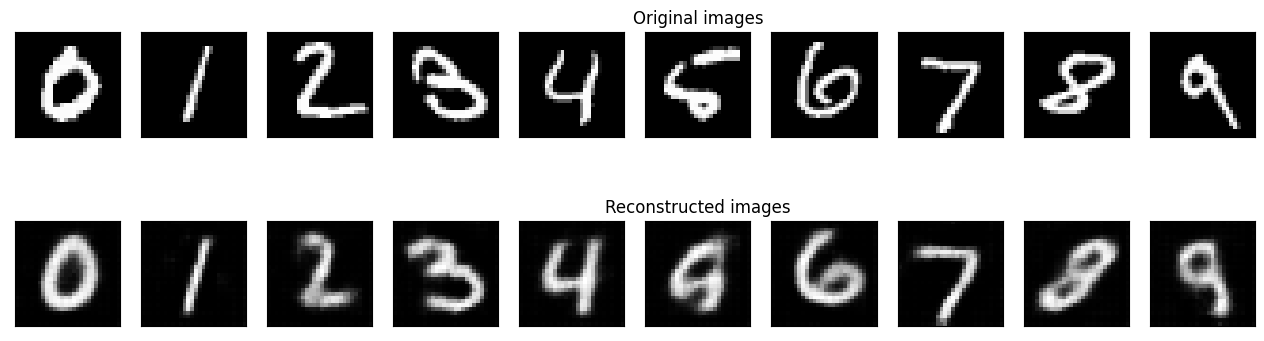

	 partial train loss (single batch): 8390.101562
	 partial train loss (single batch): 8186.851074
	 partial train loss (single batch): 8257.616211
	 partial train loss (single batch): 8373.466797
	 partial train loss (single batch): 8595.873047
	 partial train loss (single batch): 8360.623047
	 partial train loss (single batch): 8653.462891
	 partial train loss (single batch): 8352.611328
	 partial train loss (single batch): 8552.787109
	 partial train loss (single batch): 8379.296875
	 partial train loss (single batch): 8524.440430
	 partial train loss (single batch): 8387.959961
	 partial train loss (single batch): 8515.835938
	 partial train loss (single batch): 8324.718750
	 partial train loss (single batch): 8352.878906
	 partial train loss (single batch): 8534.066406
	 partial train loss (single batch): 8492.862305
	 partial train loss (single batch): 8362.882812
	 partial train loss (single batch): 8259.160156
	 partial train loss (single batch): 8432.459961
	 partial train loss

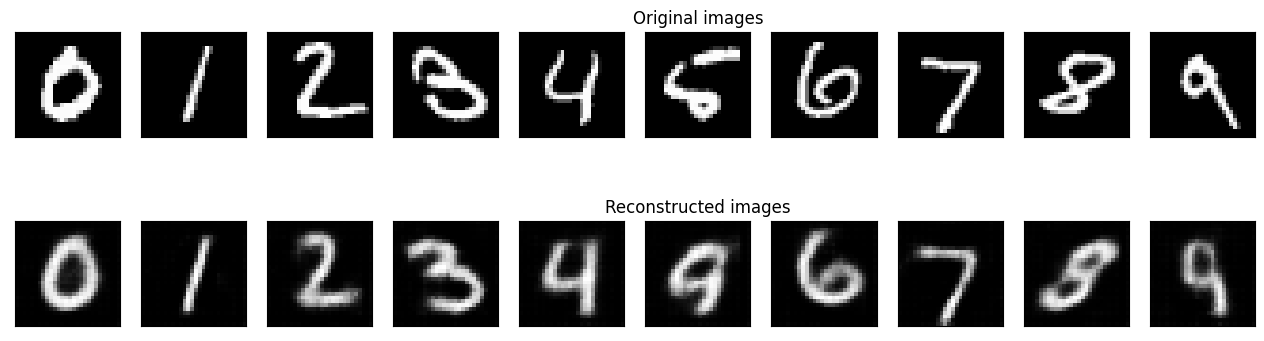

	 partial train loss (single batch): 8363.240234
	 partial train loss (single batch): 8136.053711
	 partial train loss (single batch): 8223.341797
	 partial train loss (single batch): 8429.621094
	 partial train loss (single batch): 8481.472656
	 partial train loss (single batch): 8394.915039
	 partial train loss (single batch): 8589.671875
	 partial train loss (single batch): 8416.240234
	 partial train loss (single batch): 8519.350586
	 partial train loss (single batch): 8342.375000
	 partial train loss (single batch): 8523.097656
	 partial train loss (single batch): 8376.153320
	 partial train loss (single batch): 8414.512695
	 partial train loss (single batch): 8309.681641
	 partial train loss (single batch): 8273.005859
	 partial train loss (single batch): 8536.505859
	 partial train loss (single batch): 8484.931641
	 partial train loss (single batch): 8334.724609
	 partial train loss (single batch): 8307.302734
	 partial train loss (single batch): 8426.384766
	 partial train loss

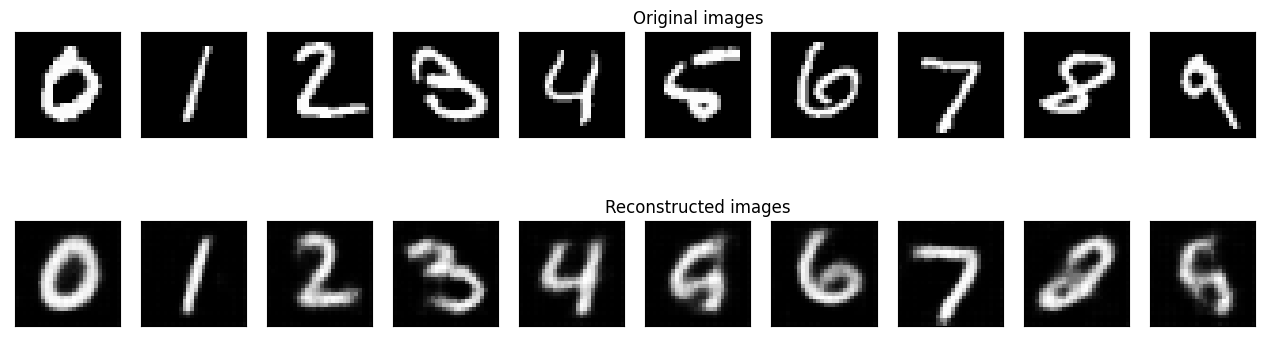

	 partial train loss (single batch): 8415.927734
	 partial train loss (single batch): 8286.437500
	 partial train loss (single batch): 8159.203613
	 partial train loss (single batch): 8367.792969
	 partial train loss (single batch): 8601.425781
	 partial train loss (single batch): 8420.247070
	 partial train loss (single batch): 8542.904297
	 partial train loss (single batch): 8327.156250
	 partial train loss (single batch): 8560.111328
	 partial train loss (single batch): 8409.605469
	 partial train loss (single batch): 8543.710938
	 partial train loss (single batch): 8425.948242
	 partial train loss (single batch): 8506.526367
	 partial train loss (single batch): 8310.877930
	 partial train loss (single batch): 8297.302734
	 partial train loss (single batch): 8468.961914
	 partial train loss (single batch): 8466.724609
	 partial train loss (single batch): 8404.683594
	 partial train loss (single batch): 8283.097656
	 partial train loss (single batch): 8380.613281
	 partial train loss

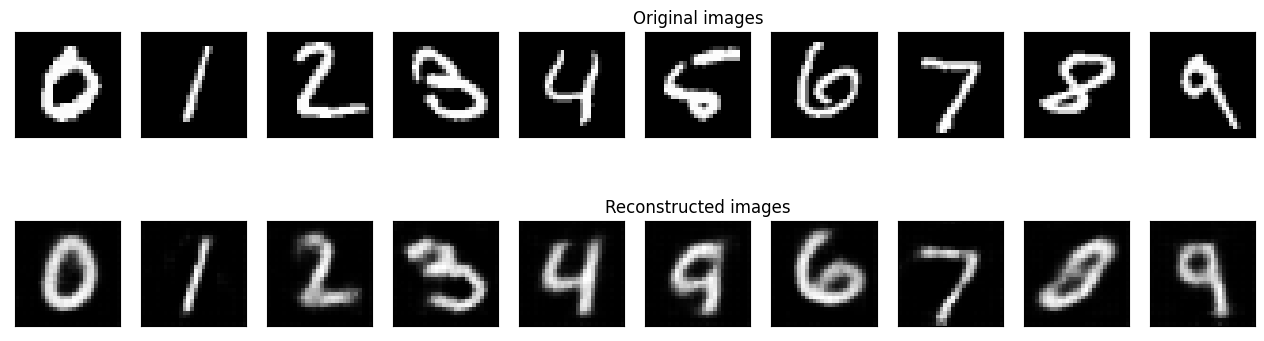

	 partial train loss (single batch): 8345.152344
	 partial train loss (single batch): 8146.262695
	 partial train loss (single batch): 8098.680664
	 partial train loss (single batch): 8366.685547
	 partial train loss (single batch): 8479.133789
	 partial train loss (single batch): 8293.820312
	 partial train loss (single batch): 8550.984375
	 partial train loss (single batch): 8331.939453
	 partial train loss (single batch): 8582.637695
	 partial train loss (single batch): 8384.339844
	 partial train loss (single batch): 8452.806641
	 partial train loss (single batch): 8387.564453
	 partial train loss (single batch): 8423.967773
	 partial train loss (single batch): 8207.321289
	 partial train loss (single batch): 8230.518555
	 partial train loss (single batch): 8443.023438
	 partial train loss (single batch): 8500.380859
	 partial train loss (single batch): 8352.472656
	 partial train loss (single batch): 8244.976562
	 partial train loss (single batch): 8355.281250
	 partial train loss

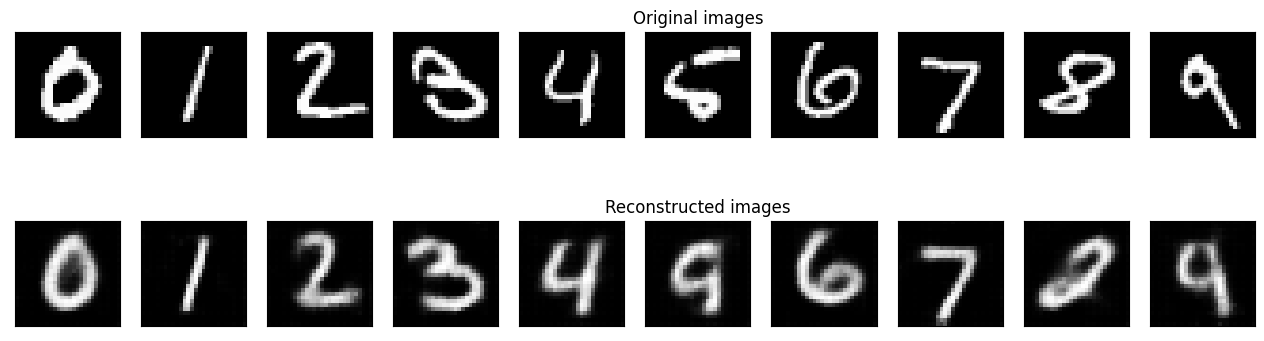

	 partial train loss (single batch): 8330.650391
	 partial train loss (single batch): 8197.078125
	 partial train loss (single batch): 8174.812012
	 partial train loss (single batch): 8383.682617
	 partial train loss (single batch): 8536.286133
	 partial train loss (single batch): 8323.118164
	 partial train loss (single batch): 8516.484375
	 partial train loss (single batch): 8422.172852
	 partial train loss (single batch): 8509.064453
	 partial train loss (single batch): 8325.260742
	 partial train loss (single batch): 8440.033203
	 partial train loss (single batch): 8368.630859
	 partial train loss (single batch): 8459.609375
	 partial train loss (single batch): 8230.089844
	 partial train loss (single batch): 8207.355469
	 partial train loss (single batch): 8434.730469
	 partial train loss (single batch): 8472.691406
	 partial train loss (single batch): 8365.285156
	 partial train loss (single batch): 8123.473145
	 partial train loss (single batch): 8361.821289
	 partial train loss

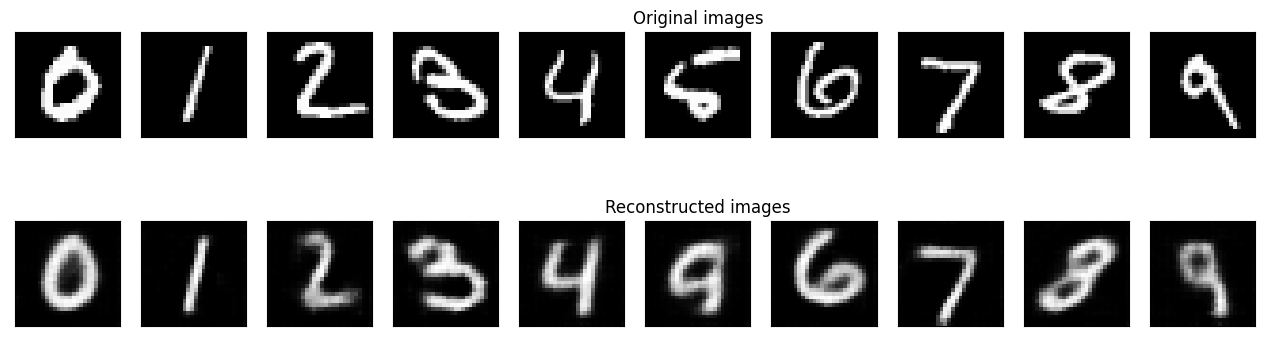

	 partial train loss (single batch): 8288.609375
	 partial train loss (single batch): 8240.962891
	 partial train loss (single batch): 8123.767578
	 partial train loss (single batch): 8421.394531
	 partial train loss (single batch): 8480.103516
	 partial train loss (single batch): 8264.685547
	 partial train loss (single batch): 8499.392578
	 partial train loss (single batch): 8304.480469
	 partial train loss (single batch): 8434.878906
	 partial train loss (single batch): 8220.140625
	 partial train loss (single batch): 8442.605469
	 partial train loss (single batch): 8328.843750
	 partial train loss (single batch): 8514.874023
	 partial train loss (single batch): 8185.998047
	 partial train loss (single batch): 8231.120117
	 partial train loss (single batch): 8486.356445
	 partial train loss (single batch): 8388.352539
	 partial train loss (single batch): 8334.049805
	 partial train loss (single batch): 8193.160156
	 partial train loss (single batch): 8324.677734
	 partial train loss

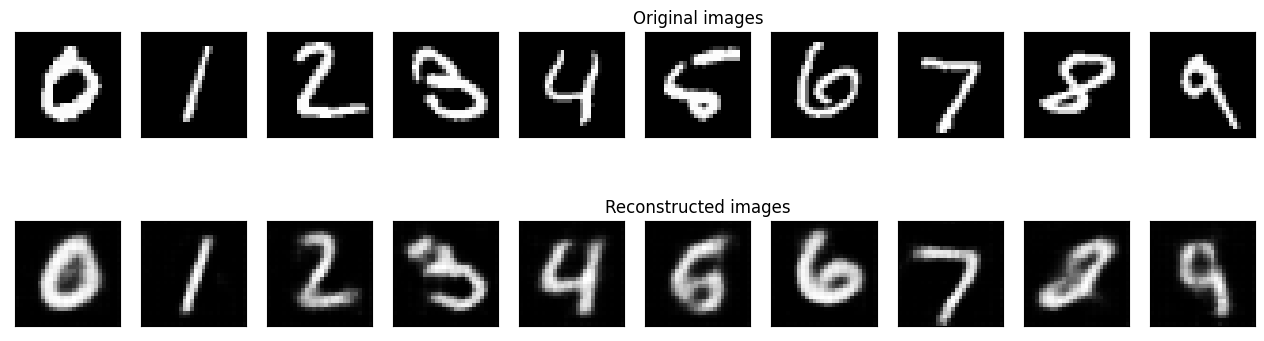

	 partial train loss (single batch): 8231.417969
	 partial train loss (single batch): 8187.011230
	 partial train loss (single batch): 8130.144531
	 partial train loss (single batch): 8323.757812
	 partial train loss (single batch): 8508.087891
	 partial train loss (single batch): 8213.747070
	 partial train loss (single batch): 8560.093750
	 partial train loss (single batch): 8325.001953
	 partial train loss (single batch): 8526.242188
	 partial train loss (single batch): 8314.746094
	 partial train loss (single batch): 8456.652344
	 partial train loss (single batch): 8336.804688
	 partial train loss (single batch): 8440.986328
	 partial train loss (single batch): 8195.060547
	 partial train loss (single batch): 8231.556641
	 partial train loss (single batch): 8404.700195
	 partial train loss (single batch): 8377.257812
	 partial train loss (single batch): 8332.427734
	 partial train loss (single batch): 8128.062988
	 partial train loss (single batch): 8326.767578
	 partial train loss

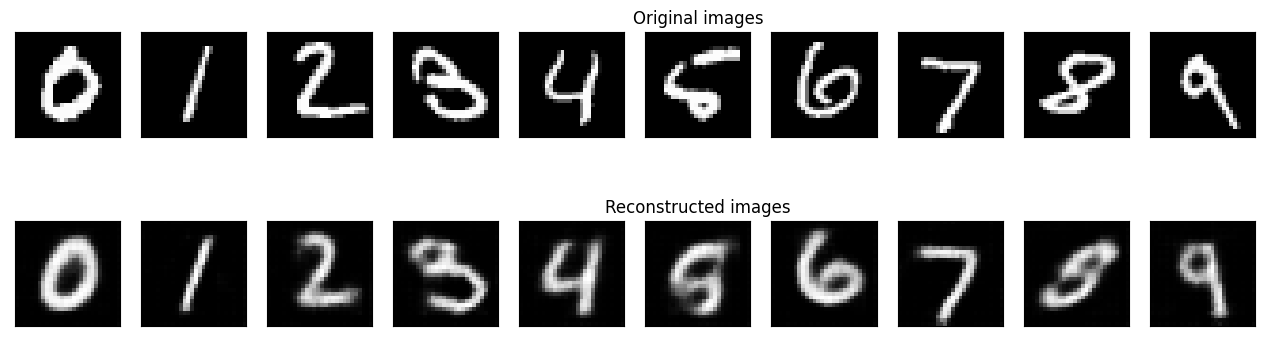

	 partial train loss (single batch): 8265.031250
	 partial train loss (single batch): 8119.847168
	 partial train loss (single batch): 8099.418945
	 partial train loss (single batch): 8335.742188
	 partial train loss (single batch): 8502.007812
	 partial train loss (single batch): 8317.908203
	 partial train loss (single batch): 8519.882812
	 partial train loss (single batch): 8219.914062
	 partial train loss (single batch): 8447.775391
	 partial train loss (single batch): 8317.822266
	 partial train loss (single batch): 8446.581055
	 partial train loss (single batch): 8368.552734
	 partial train loss (single batch): 8356.093750
	 partial train loss (single batch): 8232.865234
	 partial train loss (single batch): 8256.044922
	 partial train loss (single batch): 8451.014648
	 partial train loss (single batch): 8324.443359
	 partial train loss (single batch): 8287.073242
	 partial train loss (single batch): 8084.849609
	 partial train loss (single batch): 8300.357422
	 partial train loss

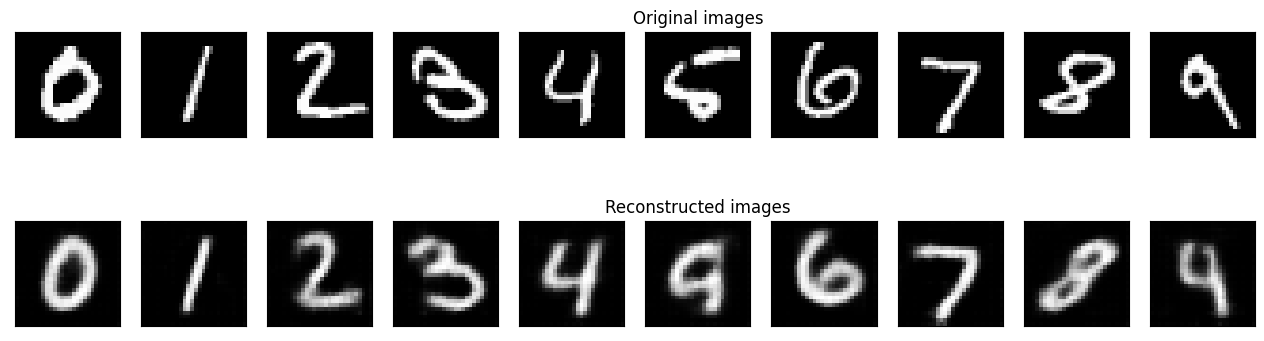

	 partial train loss (single batch): 8300.709961
	 partial train loss (single batch): 8085.787109
	 partial train loss (single batch): 8078.268066
	 partial train loss (single batch): 8305.998047
	 partial train loss (single batch): 8478.805664
	 partial train loss (single batch): 8205.071289
	 partial train loss (single batch): 8470.880859
	 partial train loss (single batch): 8252.333984
	 partial train loss (single batch): 8471.632812
	 partial train loss (single batch): 8332.225586
	 partial train loss (single batch): 8474.678711
	 partial train loss (single batch): 8265.576172
	 partial train loss (single batch): 8300.075195
	 partial train loss (single batch): 8167.897949
	 partial train loss (single batch): 8103.190918
	 partial train loss (single batch): 8408.402344
	 partial train loss (single batch): 8398.930664
	 partial train loss (single batch): 8299.875977
	 partial train loss (single batch): 8104.897949
	 partial train loss (single batch): 8266.729492
	 partial train loss

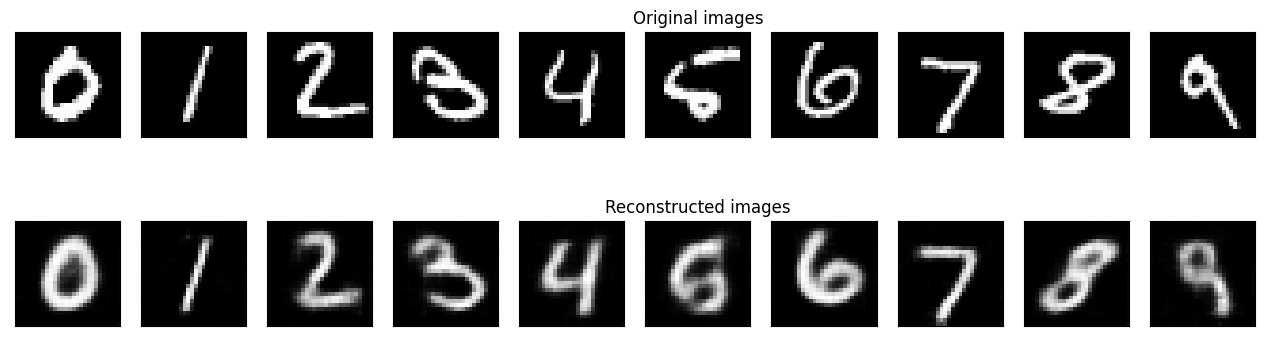

	 partial train loss (single batch): 8268.554688
	 partial train loss (single batch): 7993.159180
	 partial train loss (single batch): 8122.469727
	 partial train loss (single batch): 8294.214844
	 partial train loss (single batch): 8417.915039
	 partial train loss (single batch): 8240.708984
	 partial train loss (single batch): 8403.979492
	 partial train loss (single batch): 8246.966797
	 partial train loss (single batch): 8503.329102
	 partial train loss (single batch): 8260.314453
	 partial train loss (single batch): 8386.285156
	 partial train loss (single batch): 8308.156250
	 partial train loss (single batch): 8374.187500
	 partial train loss (single batch): 8134.423340
	 partial train loss (single batch): 8227.163086
	 partial train loss (single batch): 8398.769531
	 partial train loss (single batch): 8383.937500
	 partial train loss (single batch): 8317.230469
	 partial train loss (single batch): 8082.321289
	 partial train loss (single batch): 8332.543945
	 partial train loss

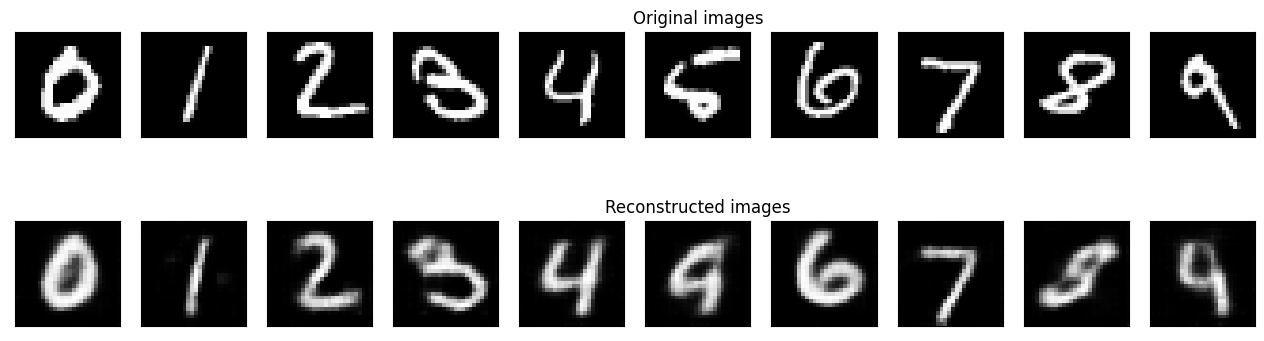

	 partial train loss (single batch): 8253.105469
	 partial train loss (single batch): 8140.870605
	 partial train loss (single batch): 8071.036621
	 partial train loss (single batch): 8305.579102
	 partial train loss (single batch): 8418.021484
	 partial train loss (single batch): 8201.263672
	 partial train loss (single batch): 8439.347656
	 partial train loss (single batch): 8242.127930
	 partial train loss (single batch): 8503.282227
	 partial train loss (single batch): 8235.328125
	 partial train loss (single batch): 8415.520508
	 partial train loss (single batch): 8314.999023
	 partial train loss (single batch): 8295.712891
	 partial train loss (single batch): 8194.530273
	 partial train loss (single batch): 8122.005371
	 partial train loss (single batch): 8371.649414
	 partial train loss (single batch): 8351.622070
	 partial train loss (single batch): 8260.107422
	 partial train loss (single batch): 8038.162109
	 partial train loss (single batch): 8266.866211
	 partial train loss

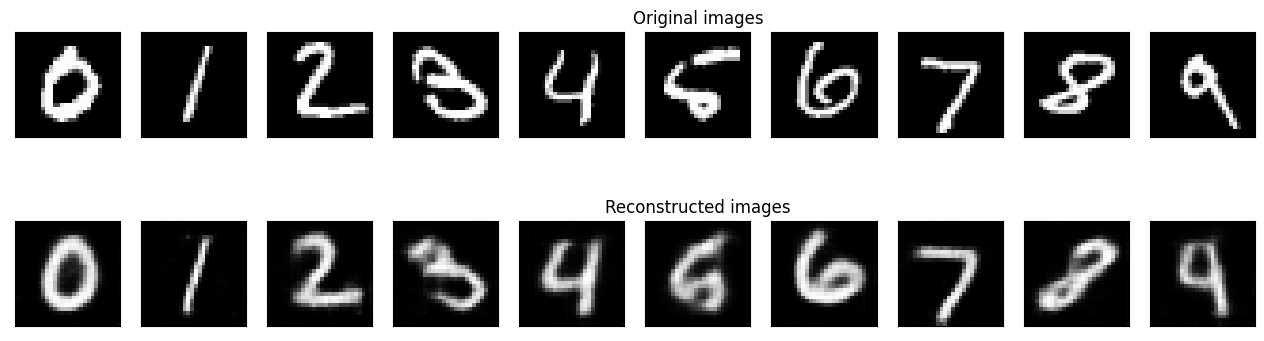

	 partial train loss (single batch): 8281.681641
	 partial train loss (single batch): 8048.986328
	 partial train loss (single batch): 8076.731445
	 partial train loss (single batch): 8423.923828
	 partial train loss (single batch): 8462.740234
	 partial train loss (single batch): 8199.478516
	 partial train loss (single batch): 8414.943359
	 partial train loss (single batch): 8201.708984
	 partial train loss (single batch): 8433.122070
	 partial train loss (single batch): 8170.566406
	 partial train loss (single batch): 8371.855469
	 partial train loss (single batch): 8306.873047
	 partial train loss (single batch): 8300.177734
	 partial train loss (single batch): 8140.208008
	 partial train loss (single batch): 8217.977539
	 partial train loss (single batch): 8314.369141
	 partial train loss (single batch): 8362.762695
	 partial train loss (single batch): 8245.693359
	 partial train loss (single batch): 8075.843750
	 partial train loss (single batch): 8284.820312
	 partial train loss

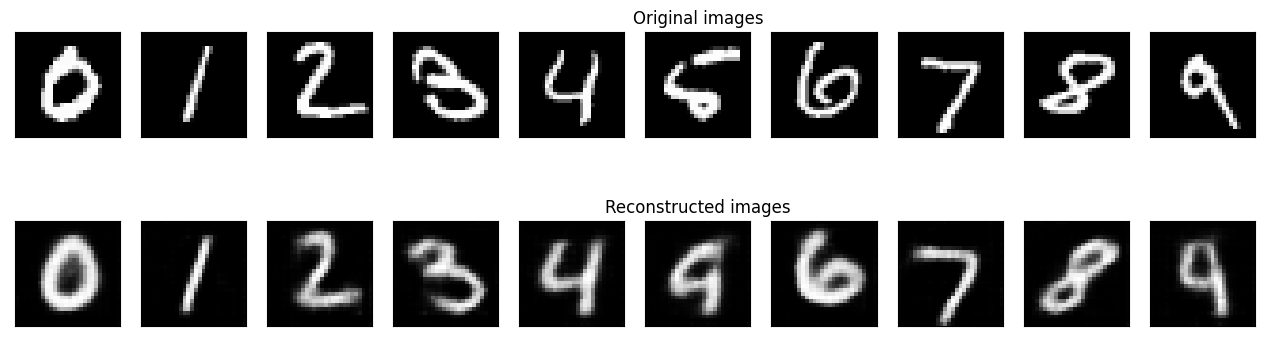

	 partial train loss (single batch): 8227.646484
	 partial train loss (single batch): 7975.525879
	 partial train loss (single batch): 8080.440430
	 partial train loss (single batch): 8226.939453
	 partial train loss (single batch): 8386.737305
	 partial train loss (single batch): 8146.110352
	 partial train loss (single batch): 8371.666016
	 partial train loss (single batch): 8171.703125
	 partial train loss (single batch): 8472.263672
	 partial train loss (single batch): 8203.198242
	 partial train loss (single batch): 8386.276367
	 partial train loss (single batch): 8237.463867
	 partial train loss (single batch): 8271.347656
	 partial train loss (single batch): 8103.458984
	 partial train loss (single batch): 8117.797852
	 partial train loss (single batch): 8317.460938
	 partial train loss (single batch): 8353.447266
	 partial train loss (single batch): 8212.343750
	 partial train loss (single batch): 8089.216309
	 partial train loss (single batch): 8329.654297
	 partial train loss

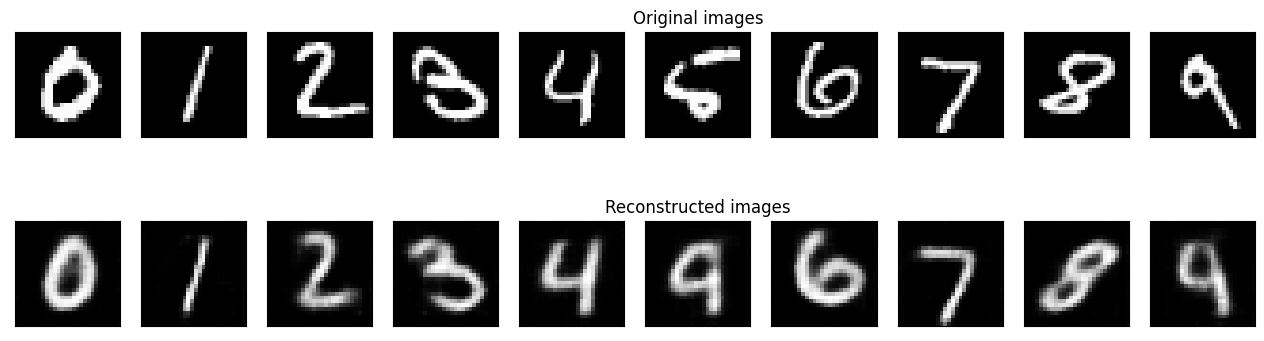

	 partial train loss (single batch): 8140.426270
	 partial train loss (single batch): 8025.838867
	 partial train loss (single batch): 8004.733398
	 partial train loss (single batch): 8243.603516
	 partial train loss (single batch): 8398.287109
	 partial train loss (single batch): 8275.453125
	 partial train loss (single batch): 8331.648438
	 partial train loss (single batch): 8235.824219
	 partial train loss (single batch): 8414.660156
	 partial train loss (single batch): 8146.930664
	 partial train loss (single batch): 8340.857422
	 partial train loss (single batch): 8260.333984
	 partial train loss (single batch): 8242.932617
	 partial train loss (single batch): 8065.250000
	 partial train loss (single batch): 8042.193848
	 partial train loss (single batch): 8281.265625
	 partial train loss (single batch): 8404.671875
	 partial train loss (single batch): 8219.923828
	 partial train loss (single batch): 8088.296875
	 partial train loss (single batch): 8262.820312
	 partial train loss

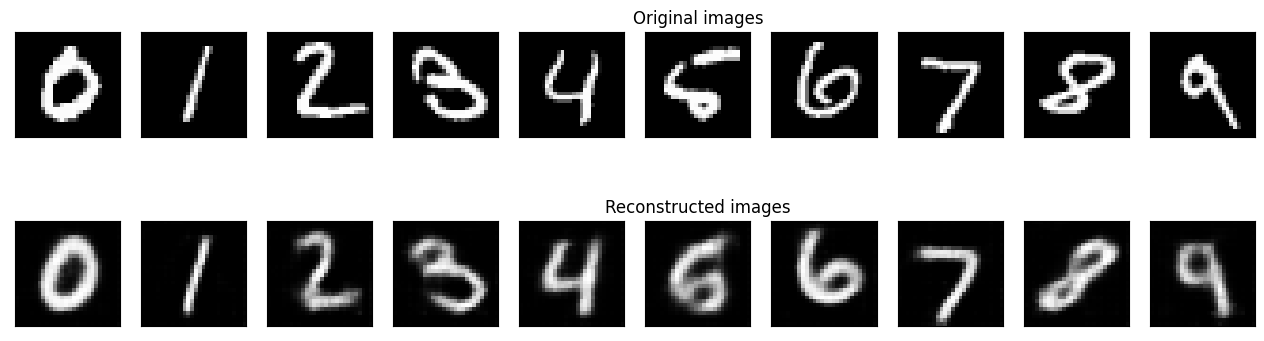

	 partial train loss (single batch): 8173.987793
	 partial train loss (single batch): 8061.930664
	 partial train loss (single batch): 8088.750488
	 partial train loss (single batch): 8335.306641
	 partial train loss (single batch): 8399.738281
	 partial train loss (single batch): 8123.712891
	 partial train loss (single batch): 8320.007812
	 partial train loss (single batch): 8206.883789
	 partial train loss (single batch): 8472.453125
	 partial train loss (single batch): 8198.239258
	 partial train loss (single batch): 8314.809570
	 partial train loss (single batch): 8237.702148
	 partial train loss (single batch): 8320.027344
	 partial train loss (single batch): 8038.419922
	 partial train loss (single batch): 8095.616699
	 partial train loss (single batch): 8287.236328
	 partial train loss (single batch): 8318.134766
	 partial train loss (single batch): 8165.544922
	 partial train loss (single batch): 8081.992188
	 partial train loss (single batch): 8322.831055
	 partial train loss

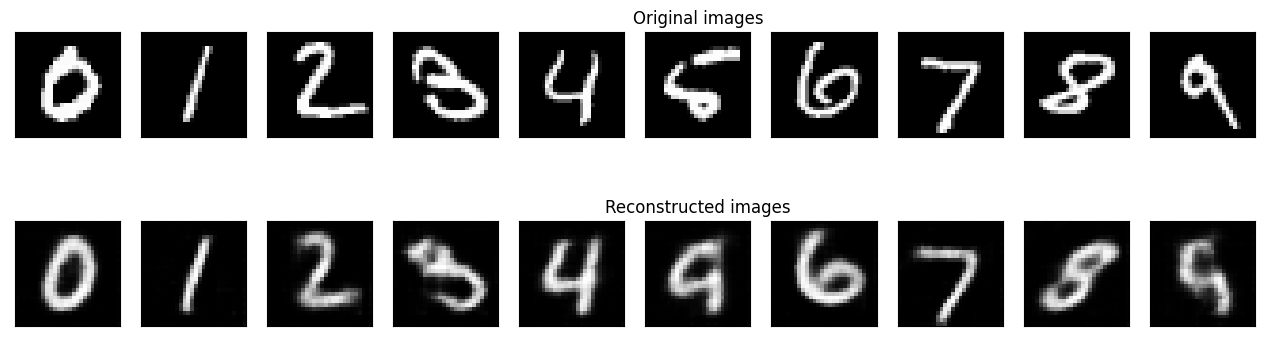

	 partial train loss (single batch): 8154.113281
	 partial train loss (single batch): 7970.495605
	 partial train loss (single batch): 7970.910156
	 partial train loss (single batch): 8132.319336
	 partial train loss (single batch): 8387.726562
	 partial train loss (single batch): 8121.895508
	 partial train loss (single batch): 8468.429688
	 partial train loss (single batch): 8218.127930
	 partial train loss (single batch): 8451.167969
	 partial train loss (single batch): 8139.002441
	 partial train loss (single batch): 8394.665039
	 partial train loss (single batch): 8238.927734
	 partial train loss (single batch): 8268.015625
	 partial train loss (single batch): 8092.753418
	 partial train loss (single batch): 8094.531250
	 partial train loss (single batch): 8341.868164
	 partial train loss (single batch): 8383.692383
	 partial train loss (single batch): 8156.524414
	 partial train loss (single batch): 8083.396973
	 partial train loss (single batch): 8302.624023
	 partial train loss

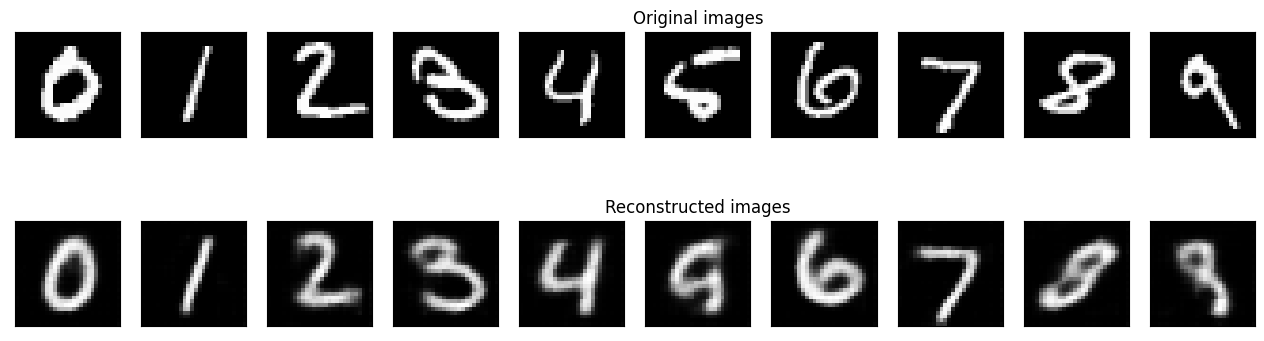

	 partial train loss (single batch): 8139.132812
	 partial train loss (single batch): 7974.436523
	 partial train loss (single batch): 8082.005859
	 partial train loss (single batch): 8320.685547
	 partial train loss (single batch): 8404.357422
	 partial train loss (single batch): 8197.296875
	 partial train loss (single batch): 8326.944336
	 partial train loss (single batch): 8202.890625
	 partial train loss (single batch): 8360.790039
	 partial train loss (single batch): 8135.896484
	 partial train loss (single batch): 8359.845703
	 partial train loss (single batch): 8270.262695
	 partial train loss (single batch): 8248.875000
	 partial train loss (single batch): 8025.462891
	 partial train loss (single batch): 8083.899414
	 partial train loss (single batch): 8269.941406
	 partial train loss (single batch): 8330.777344
	 partial train loss (single batch): 8226.787109
	 partial train loss (single batch): 8012.003906
	 partial train loss (single batch): 8191.595703
	 partial train loss

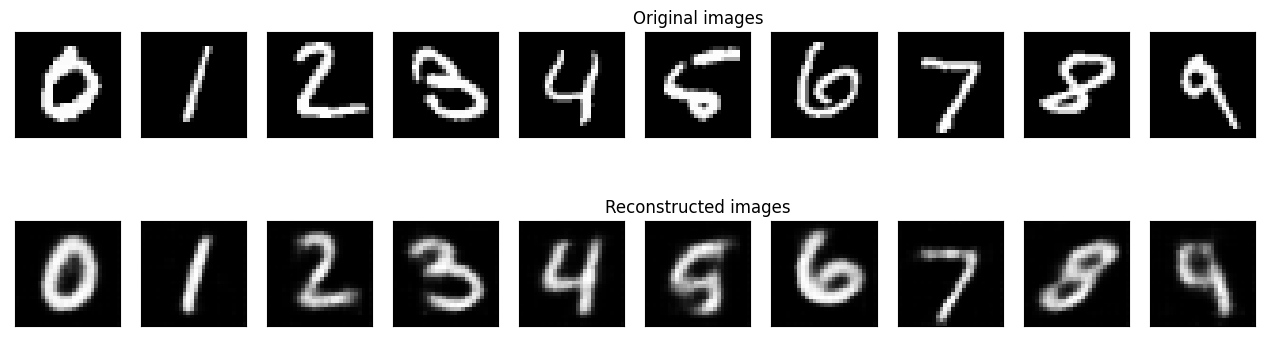

	 partial train loss (single batch): 8186.041992
	 partial train loss (single batch): 8027.841797
	 partial train loss (single batch): 8035.474609
	 partial train loss (single batch): 8192.171875
	 partial train loss (single batch): 8296.578125
	 partial train loss (single batch): 8118.721191
	 partial train loss (single batch): 8331.714844
	 partial train loss (single batch): 8155.104980
	 partial train loss (single batch): 8419.912109
	 partial train loss (single batch): 8142.639160
	 partial train loss (single batch): 8308.316406
	 partial train loss (single batch): 8228.058594
	 partial train loss (single batch): 8311.814453
	 partial train loss (single batch): 7981.364258
	 partial train loss (single batch): 8100.268066
	 partial train loss (single batch): 8226.732422
	 partial train loss (single batch): 8286.237305
	 partial train loss (single batch): 8170.579590
	 partial train loss (single batch): 8020.522949
	 partial train loss (single batch): 8165.972656
	 partial train loss

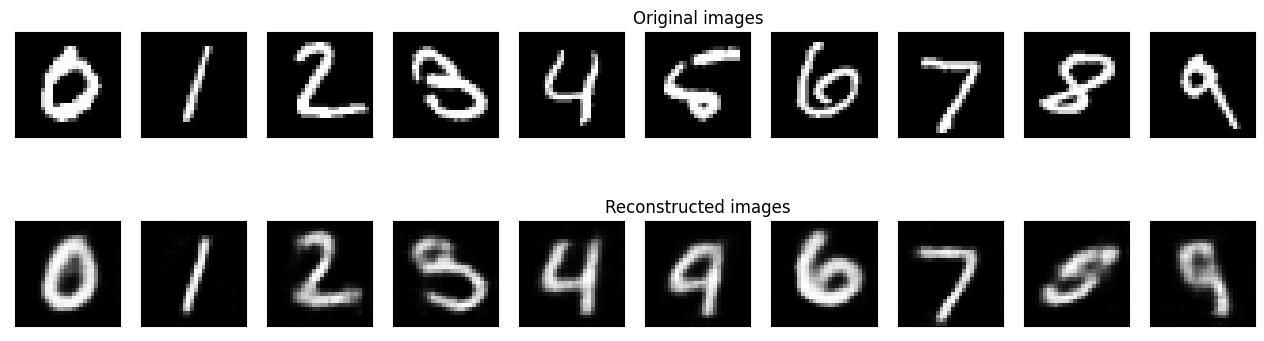

	 partial train loss (single batch): 8127.217285
	 partial train loss (single batch): 7980.456543
	 partial train loss (single batch): 8045.952637
	 partial train loss (single batch): 8237.028320
	 partial train loss (single batch): 8369.561523
	 partial train loss (single batch): 8106.297852
	 partial train loss (single batch): 8414.640625
	 partial train loss (single batch): 8120.604980
	 partial train loss (single batch): 8408.732422
	 partial train loss (single batch): 8125.679199
	 partial train loss (single batch): 8358.838867
	 partial train loss (single batch): 8197.422852
	 partial train loss (single batch): 8270.208984
	 partial train loss (single batch): 8090.024414
	 partial train loss (single batch): 8049.960938
	 partial train loss (single batch): 8203.443359
	 partial train loss (single batch): 8220.570312
	 partial train loss (single batch): 8192.437500
	 partial train loss (single batch): 8011.970703
	 partial train loss (single batch): 8333.531250
	 partial train loss

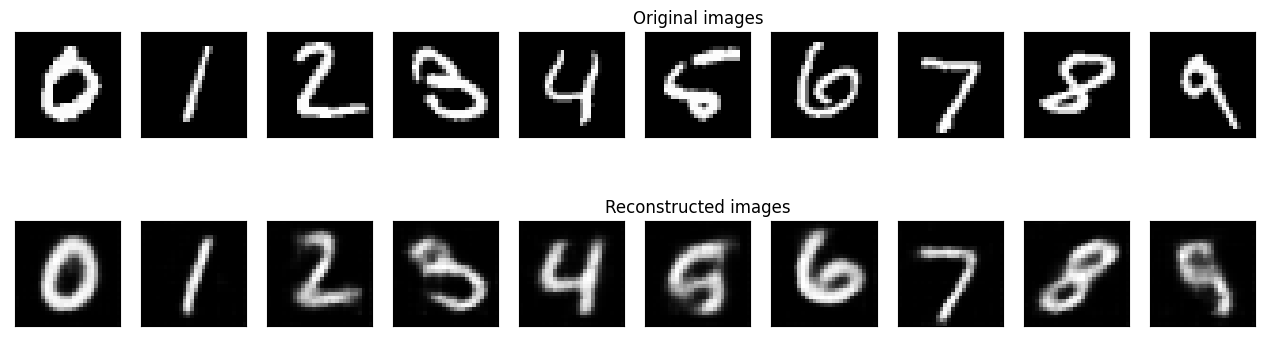

	 partial train loss (single batch): 8093.589844
	 partial train loss (single batch): 7987.049316
	 partial train loss (single batch): 8061.041504
	 partial train loss (single batch): 8206.333984
	 partial train loss (single batch): 8329.234375
	 partial train loss (single batch): 7992.034180
	 partial train loss (single batch): 8262.848633
	 partial train loss (single batch): 8137.941895
	 partial train loss (single batch): 8387.556641
	 partial train loss (single batch): 8159.617188
	 partial train loss (single batch): 8225.343750
	 partial train loss (single batch): 8198.017578
	 partial train loss (single batch): 8281.539062
	 partial train loss (single batch): 8017.038086
	 partial train loss (single batch): 8038.187500
	 partial train loss (single batch): 8310.619141
	 partial train loss (single batch): 8259.464844
	 partial train loss (single batch): 8138.728516
	 partial train loss (single batch): 8054.454102
	 partial train loss (single batch): 8178.513184
	 partial train loss

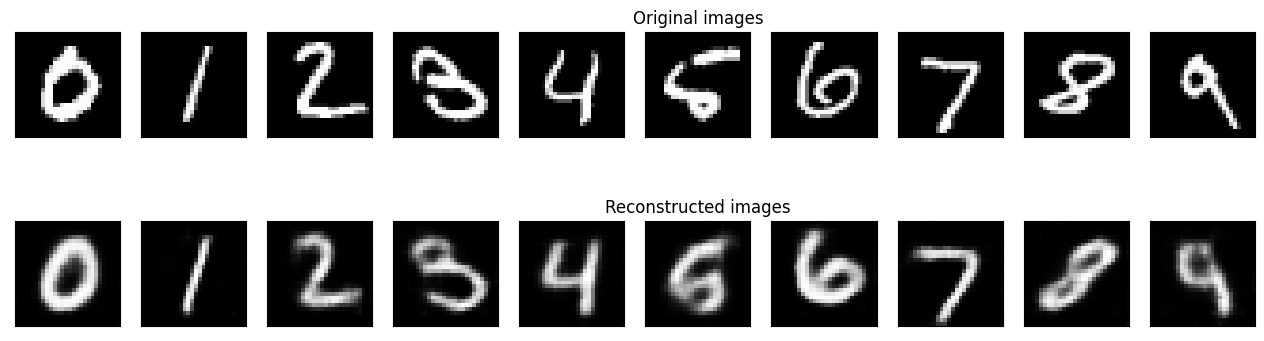

	 partial train loss (single batch): 8072.383789
	 partial train loss (single batch): 7998.294922
	 partial train loss (single batch): 8020.770996
	 partial train loss (single batch): 8193.079102
	 partial train loss (single batch): 8364.960938
	 partial train loss (single batch): 8107.021973
	 partial train loss (single batch): 8318.318359
	 partial train loss (single batch): 8065.995605
	 partial train loss (single batch): 8439.123047
	 partial train loss (single batch): 8144.849609
	 partial train loss (single batch): 8315.458984
	 partial train loss (single batch): 8166.860352
	 partial train loss (single batch): 8140.554199
	 partial train loss (single batch): 8015.122070
	 partial train loss (single batch): 7962.178711
	 partial train loss (single batch): 8280.576172
	 partial train loss (single batch): 8255.478516
	 partial train loss (single batch): 8028.379883
	 partial train loss (single batch): 7962.930664
	 partial train loss (single batch): 8240.867188
	 partial train loss

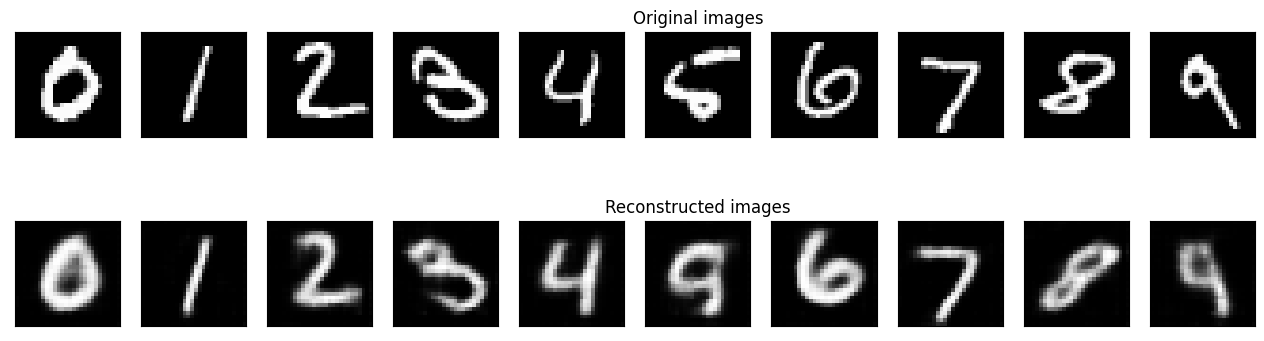

	 partial train loss (single batch): 8123.710938
	 partial train loss (single batch): 7954.511230
	 partial train loss (single batch): 7966.541016
	 partial train loss (single batch): 8161.248535
	 partial train loss (single batch): 8309.074219
	 partial train loss (single batch): 8160.980957
	 partial train loss (single batch): 8320.275391
	 partial train loss (single batch): 8141.886230
	 partial train loss (single batch): 8373.768555
	 partial train loss (single batch): 8097.251465
	 partial train loss (single batch): 8329.702148
	 partial train loss (single batch): 8240.888672
	 partial train loss (single batch): 8218.030273
	 partial train loss (single batch): 8085.966309
	 partial train loss (single batch): 7960.301270
	 partial train loss (single batch): 8239.896484
	 partial train loss (single batch): 8244.234375
	 partial train loss (single batch): 8124.220703
	 partial train loss (single batch): 7901.468750
	 partial train loss (single batch): 8157.462891
	 partial train loss

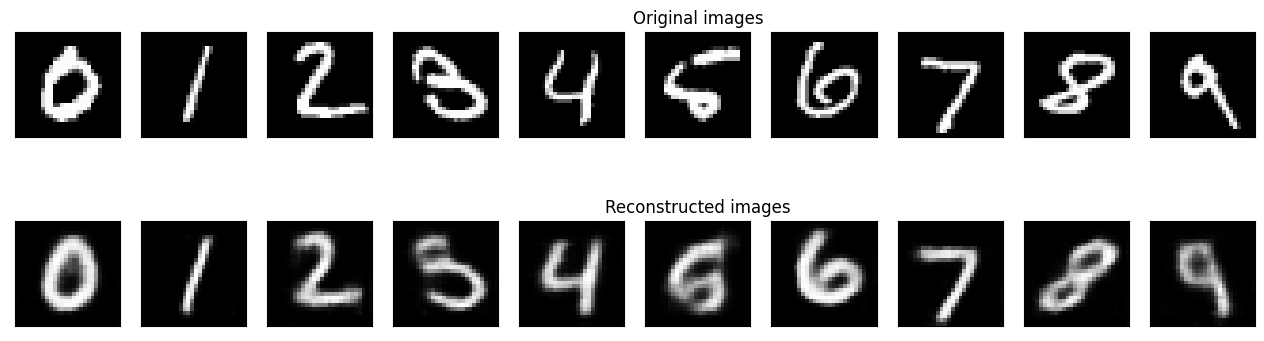

	 partial train loss (single batch): 8084.381348
	 partial train loss (single batch): 7986.033203
	 partial train loss (single batch): 8035.851562
	 partial train loss (single batch): 8168.134766
	 partial train loss (single batch): 8250.390625
	 partial train loss (single batch): 8100.861816
	 partial train loss (single batch): 8232.753906
	 partial train loss (single batch): 8073.916504
	 partial train loss (single batch): 8300.796875
	 partial train loss (single batch): 8087.995605
	 partial train loss (single batch): 8268.183594
	 partial train loss (single batch): 8193.460938
	 partial train loss (single batch): 8200.611328
	 partial train loss (single batch): 8008.736328
	 partial train loss (single batch): 7966.119141
	 partial train loss (single batch): 8225.947266
	 partial train loss (single batch): 8262.204102
	 partial train loss (single batch): 8177.341797
	 partial train loss (single batch): 7963.106445
	 partial train loss (single batch): 8130.280762
	 partial train loss

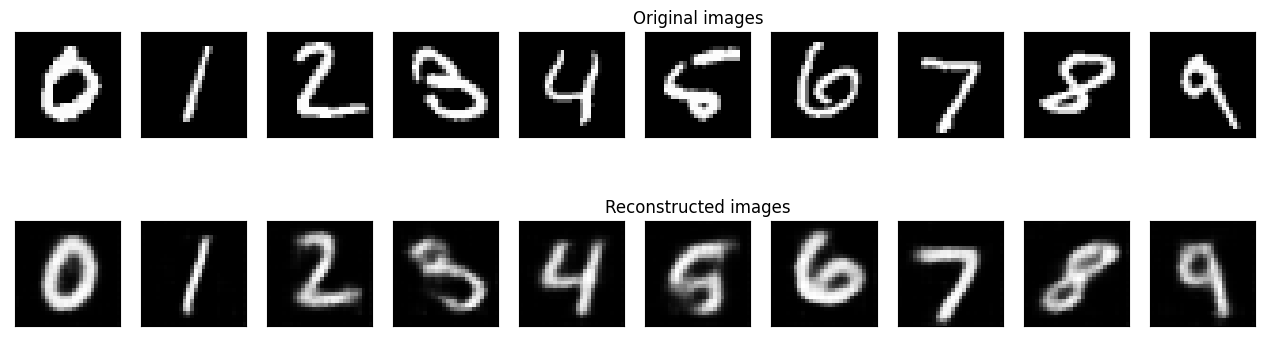

	 partial train loss (single batch): 8102.105469
	 partial train loss (single batch): 7941.825195
	 partial train loss (single batch): 7971.370117
	 partial train loss (single batch): 8197.160156
	 partial train loss (single batch): 8291.113281
	 partial train loss (single batch): 8130.621094
	 partial train loss (single batch): 8200.482422
	 partial train loss (single batch): 8125.534180
	 partial train loss (single batch): 8305.312500
	 partial train loss (single batch): 8031.087402
	 partial train loss (single batch): 8371.838867
	 partial train loss (single batch): 8123.110352
	 partial train loss (single batch): 8185.112305
	 partial train loss (single batch): 8009.456055
	 partial train loss (single batch): 7984.946289
	 partial train loss (single batch): 8270.921875
	 partial train loss (single batch): 8232.308594
	 partial train loss (single batch): 8133.310547
	 partial train loss (single batch): 7965.602051
	 partial train loss (single batch): 8124.356934
	 partial train loss

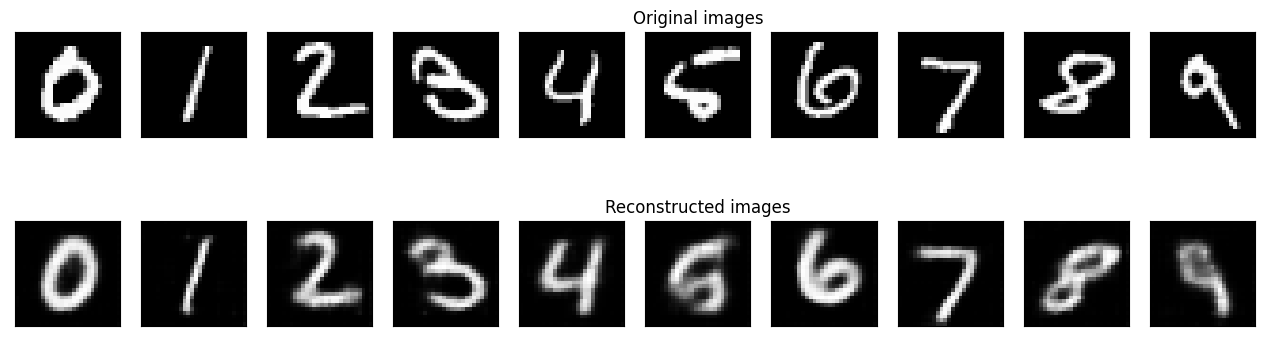

	 partial train loss (single batch): 8034.080566
	 partial train loss (single batch): 7990.912109
	 partial train loss (single batch): 8036.764648
	 partial train loss (single batch): 8178.929199
	 partial train loss (single batch): 8288.945312
	 partial train loss (single batch): 8074.314941
	 partial train loss (single batch): 8224.324219
	 partial train loss (single batch): 8055.039062
	 partial train loss (single batch): 8337.064453
	 partial train loss (single batch): 8019.497070
	 partial train loss (single batch): 8250.132812
	 partial train loss (single batch): 8163.085938
	 partial train loss (single batch): 8113.230957
	 partial train loss (single batch): 7962.996094
	 partial train loss (single batch): 7970.017578
	 partial train loss (single batch): 8294.707031
	 partial train loss (single batch): 8202.056641
	 partial train loss (single batch): 8113.033203
	 partial train loss (single batch): 7968.250000
	 partial train loss (single batch): 8152.394043
	 partial train loss

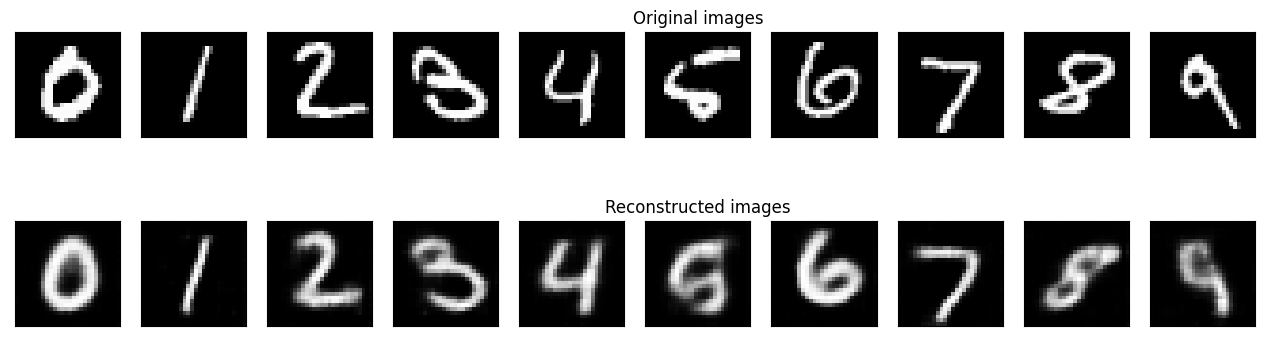

	 partial train loss (single batch): 8068.349121
	 partial train loss (single batch): 8005.068359
	 partial train loss (single batch): 8009.769531
	 partial train loss (single batch): 8116.006348
	 partial train loss (single batch): 8316.040039
	 partial train loss (single batch): 8085.578125
	 partial train loss (single batch): 8191.291016
	 partial train loss (single batch): 8112.781250
	 partial train loss (single batch): 8306.634766
	 partial train loss (single batch): 8139.217773
	 partial train loss (single batch): 8236.859375
	 partial train loss (single batch): 8111.483398
	 partial train loss (single batch): 8110.511719
	 partial train loss (single batch): 7982.516113
	 partial train loss (single batch): 8003.084473
	 partial train loss (single batch): 8206.482422
	 partial train loss (single batch): 8275.238281
	 partial train loss (single batch): 8073.871094
	 partial train loss (single batch): 8092.094727
	 partial train loss (single batch): 8173.048828
	 partial train loss

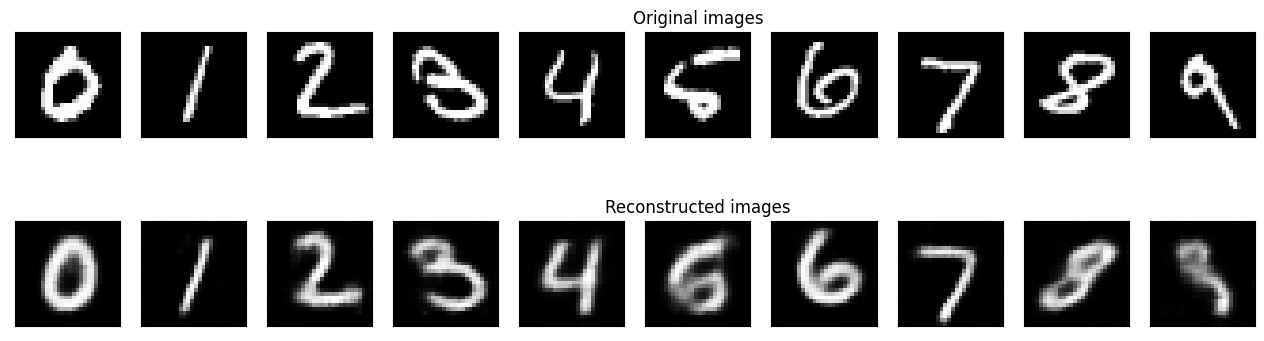

	 partial train loss (single batch): 8044.291992
	 partial train loss (single batch): 7988.872070
	 partial train loss (single batch): 7976.161133
	 partial train loss (single batch): 8203.056641
	 partial train loss (single batch): 8352.936523
	 partial train loss (single batch): 8082.836426
	 partial train loss (single batch): 8287.000977
	 partial train loss (single batch): 8026.302246
	 partial train loss (single batch): 8326.157227
	 partial train loss (single batch): 8072.652344
	 partial train loss (single batch): 8268.220703
	 partial train loss (single batch): 8190.898438
	 partial train loss (single batch): 8155.568359
	 partial train loss (single batch): 8010.453125
	 partial train loss (single batch): 8071.757812
	 partial train loss (single batch): 8265.427734
	 partial train loss (single batch): 8310.830078
	 partial train loss (single batch): 8108.310059
	 partial train loss (single batch): 7973.594727
	 partial train loss (single batch): 8162.890625
	 partial train loss

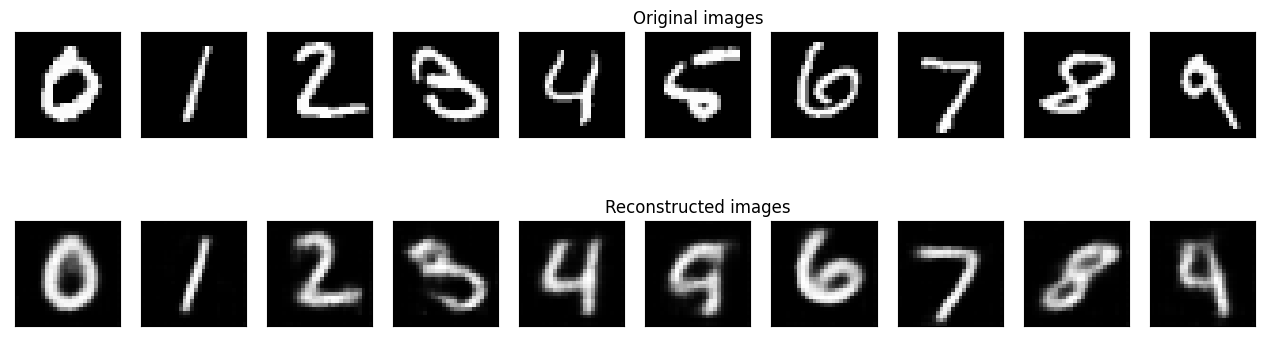

	 partial train loss (single batch): 8035.698730
	 partial train loss (single batch): 7888.040527
	 partial train loss (single batch): 7924.778320
	 partial train loss (single batch): 8194.767578
	 partial train loss (single batch): 8304.363281
	 partial train loss (single batch): 8119.626953
	 partial train loss (single batch): 8257.409180
	 partial train loss (single batch): 8073.879395
	 partial train loss (single batch): 8395.638672
	 partial train loss (single batch): 8061.656250
	 partial train loss (single batch): 8280.425781
	 partial train loss (single batch): 8082.797852
	 partial train loss (single batch): 8156.050781
	 partial train loss (single batch): 8030.663574
	 partial train loss (single batch): 7966.596191
	 partial train loss (single batch): 8215.589844
	 partial train loss (single batch): 8266.433594
	 partial train loss (single batch): 8008.337891
	 partial train loss (single batch): 7974.985352
	 partial train loss (single batch): 8160.729980
	 partial train loss

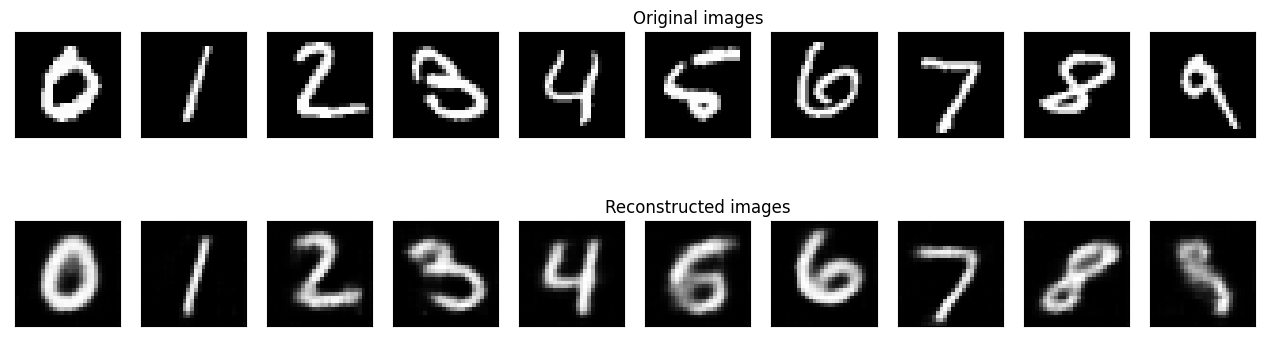

	 partial train loss (single batch): 8054.789062
	 partial train loss (single batch): 7946.658691
	 partial train loss (single batch): 8009.454590
	 partial train loss (single batch): 8149.354492
	 partial train loss (single batch): 8335.523438
	 partial train loss (single batch): 8022.512695
	 partial train loss (single batch): 8220.419922
	 partial train loss (single batch): 8134.723145
	 partial train loss (single batch): 8274.386719
	 partial train loss (single batch): 8056.015625
	 partial train loss (single batch): 8264.756836
	 partial train loss (single batch): 8121.946289
	 partial train loss (single batch): 8173.979492
	 partial train loss (single batch): 7950.926270
	 partial train loss (single batch): 7961.829102
	 partial train loss (single batch): 8221.972656
	 partial train loss (single batch): 8206.074219
	 partial train loss (single batch): 8079.856445
	 partial train loss (single batch): 7870.429688
	 partial train loss (single batch): 8107.607422
	 partial train loss

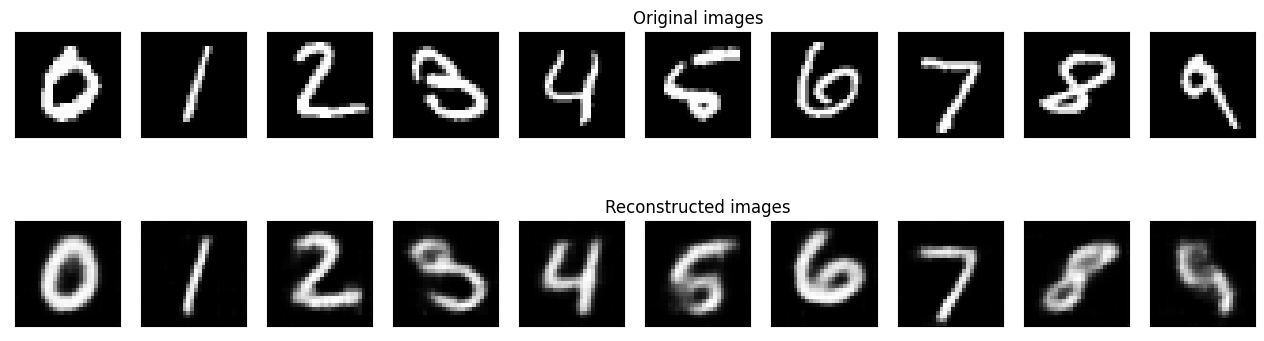

	 partial train loss (single batch): 8066.438965
	 partial train loss (single batch): 7953.087402
	 partial train loss (single batch): 7921.732422
	 partial train loss (single batch): 8163.876465
	 partial train loss (single batch): 8252.441406
	 partial train loss (single batch): 7997.977539
	 partial train loss (single batch): 8220.291992
	 partial train loss (single batch): 8173.373535
	 partial train loss (single batch): 8367.843750
	 partial train loss (single batch): 8051.153320
	 partial train loss (single batch): 8216.175781
	 partial train loss (single batch): 8135.788574
	 partial train loss (single batch): 8176.352539
	 partial train loss (single batch): 7967.869629
	 partial train loss (single batch): 7999.325195
	 partial train loss (single batch): 8154.312500
	 partial train loss (single batch): 8261.763672
	 partial train loss (single batch): 7989.135742
	 partial train loss (single batch): 7964.287598
	 partial train loss (single batch): 8116.513184
	 partial train loss

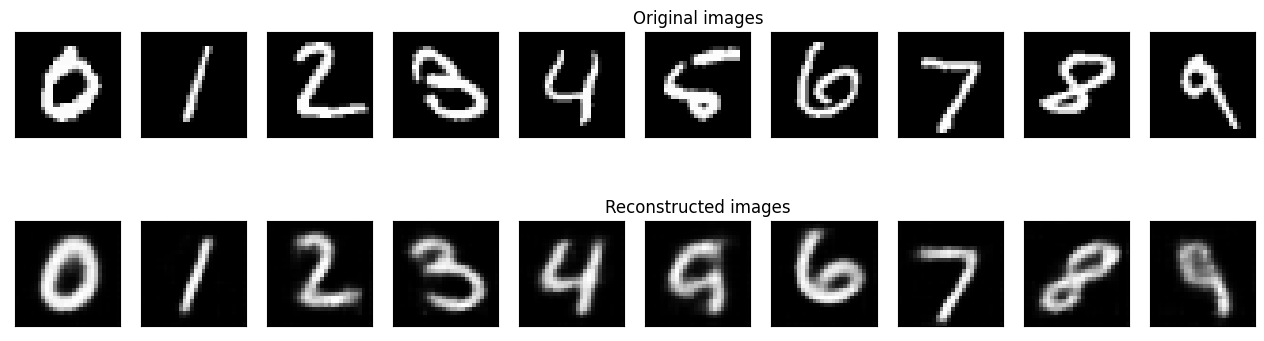

	 partial train loss (single batch): 8038.020508
	 partial train loss (single batch): 7936.462891
	 partial train loss (single batch): 7953.522461
	 partial train loss (single batch): 8151.216797
	 partial train loss (single batch): 8293.332031
	 partial train loss (single batch): 7996.889160
	 partial train loss (single batch): 8281.827148
	 partial train loss (single batch): 8075.024414
	 partial train loss (single batch): 8280.357422
	 partial train loss (single batch): 8035.558594
	 partial train loss (single batch): 8282.662109
	 partial train loss (single batch): 8132.144531
	 partial train loss (single batch): 8138.078125
	 partial train loss (single batch): 7967.281738
	 partial train loss (single batch): 7961.340820
	 partial train loss (single batch): 8224.998047
	 partial train loss (single batch): 8208.489258
	 partial train loss (single batch): 8042.544922
	 partial train loss (single batch): 7945.785645
	 partial train loss (single batch): 8162.643555
	 partial train loss

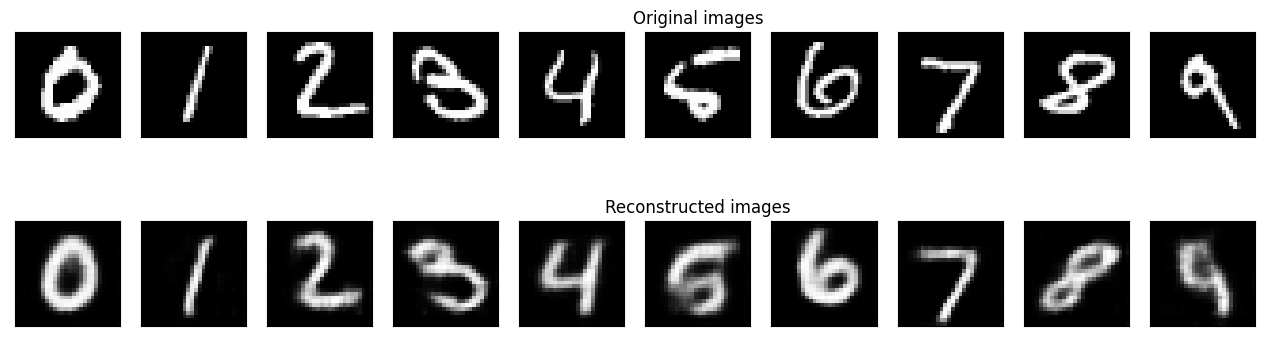

	 partial train loss (single batch): 8054.848633
	 partial train loss (single batch): 7895.682129
	 partial train loss (single batch): 7865.899414
	 partial train loss (single batch): 8107.838379
	 partial train loss (single batch): 8281.731445
	 partial train loss (single batch): 8058.644531
	 partial train loss (single batch): 8202.498047
	 partial train loss (single batch): 8036.270996
	 partial train loss (single batch): 8262.723633
	 partial train loss (single batch): 8002.339844
	 partial train loss (single batch): 8236.191406
	 partial train loss (single batch): 8176.804688
	 partial train loss (single batch): 8129.621094
	 partial train loss (single batch): 7941.456543
	 partial train loss (single batch): 7930.630859
	 partial train loss (single batch): 8175.372070
	 partial train loss (single batch): 8269.884766
	 partial train loss (single batch): 7996.145508
	 partial train loss (single batch): 7994.216309
	 partial train loss (single batch): 8146.311523
	 partial train loss

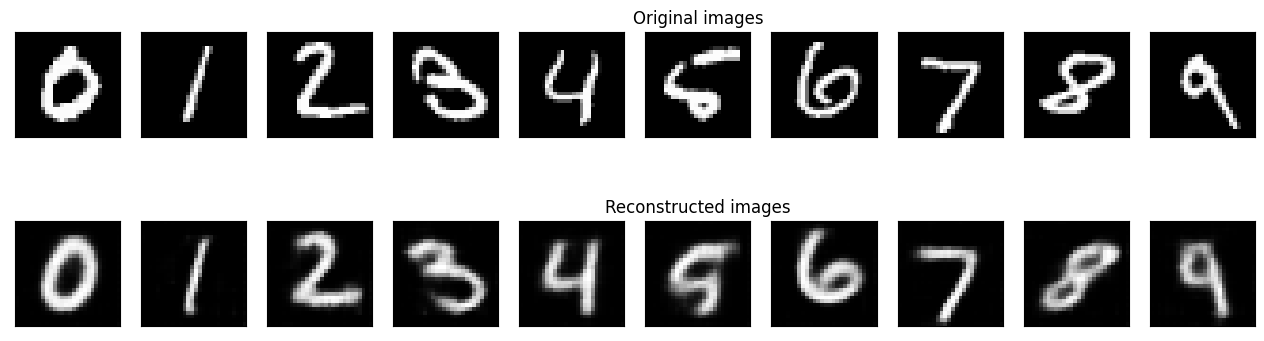

In [67]:
num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(vae.encoder,vae.decoder,n=10)

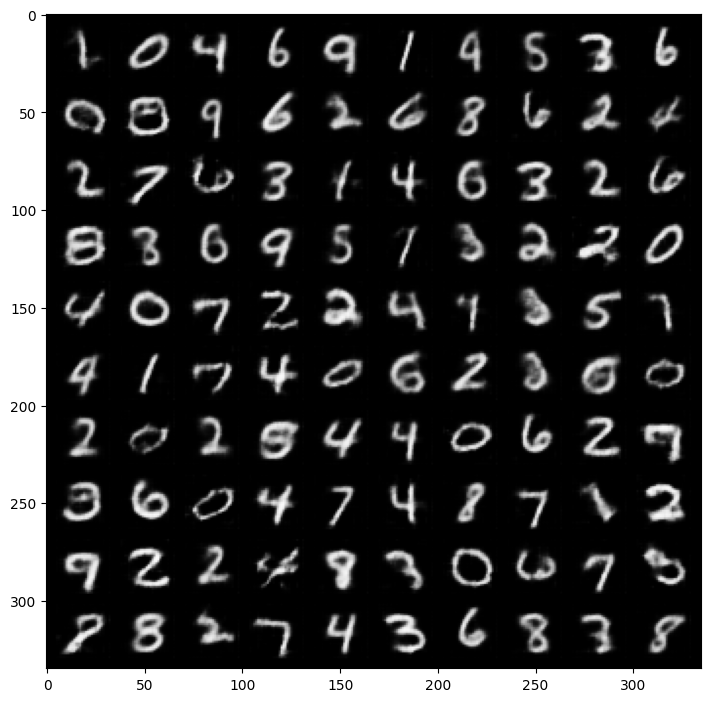

In [68]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    torch.manual_seed(3.14)
    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

In [77]:
zero = []
zero_indicies = [i for i, label in enumerate(train_dataset.targets) if label == 0]
zero_data = [train_dataset.data[i] for i in zero_indicies]
image = zero_data[1]

#plt.imshow(image, cmap='gray')
#plt.show()

#fig, ax = plt.subplots(figsize=(20, 8.5))
#show_image(torchvision.utils.make_grid(zero_data[:100],10,5))
#plt.show()

def display(images):
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))
    for i, image in enumerate(images):
        axs[i // 10, i % 10].imshow(image, cmap='gray')
    plt.show()

#display(zero_data[:100])

image_tensor = torch.tensor(zero_data[0], dtype=torch.float32, device=device)
print(image_tensor.shape)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.unsqueeze(0)
print(image_tensor.shape)

vae.eval()

z, mu, sigma = vae.encoder(image_tensor)
print([x.squeeze() for x in (z, mu, sigma)])

torch.Size([28, 28])
torch.Size([1, 1, 28, 28])
[tensor([-65.6771,  17.8675, -41.1775, -92.2256], device='cuda:0',
       grad_fn=<SqueezeBackward0>), tensor([-65.6771,  17.8675, -41.1775, -92.2256], device='cuda:0',
       grad_fn=<SqueezeBackward0>), tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)]


/tmp/ipykernel_24384/2340601960.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(zero_data[0], dtype=torch.float32, device=device)


In [ ]:
# decode
z = mu + sigma*self.N.sample(mu.shape)